In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option('display.float_format', lambda x: '%.6f' % x)

# Evaluation of Malde-A cost function in quality Levenshtein mode

The following notebook examines the clustering quality of the different variants of the Malde-A cost function when running GeFaST in quality Levenshtein mode.
The evaluation uses the results on the Callahan data sets and on the Franzén data sets:
 - Callahan et al., *DADA2: High-resolution sample inference from Illumina amplicon data* (https://doi.org/10.1038/nmeth.3869)
 - Franzén et al., *Improved OTU-picking using long-read 16S rRNA gene amplicon sequencing and generic hierarchical clustering* (https://doi.org/10.1186/s40168-015-0105-6)
 
This evaluation relies on the CSV outputs of the notebooks of the evaluations specific to the different tools and data sets.
The required files are listed below.
The variant considered best is included in the overall evaluation of the quality-weighted clustering methods in `quality_weighted_overall.ipynb`.
 
### GeFaST variants
GeFaST is evaluated in Levenshtein mode (as a reference) and in quality Levenshtein mode using the Malde-A cost function with different boosting functions (`linear`, `mult`, `root`).

The different (quality-weighted) variants are usually referred to by an abbreviation hinting at the mode, quality-weighting technique and boosting function (including parameters): `<variant>_<boosting>_qlev-ma`, e.g. `mw_unboosted_qlev-ma` and `v1_root2_qlev-ma`.
The completely unweighted variant in Levenshtein mode is denoted as `original_lev`.

Values of `<variant>`:

| Abbreviation | Description |
| --: | :-- |
| muw | matches in an alignment are *not* quality-weighted, unboosted variant |
| mw  | matches in an alignment are quality-weighted, unboosted variant |
| v1  | matches in an alignment are quality-weighted, inner boosting |
| v2  | matches in an alignment are *not* quality-weighted, inner boosting |
| v3  | matches in an alignment are quality-weighted, outer boosting |
| v4  | matches in an alignment are *not* quality-weighted, outer boosting |

Values of `<boosting>`:

| Abbreviation | Description |
| --: | :-- |
| unboosted    | unboosted variant |
| linear*x*    | linear boosting starting at `linear_start` = *x*  |
| mult*x*      | multiplicative boosting with `mult_factor` = *x* |
| root*x*      | unshifted root boosting with `root_degree` = *x* |
| rootshift*x* | shifted root boosting with `root_degree` = *x* and `root_shift` = *full* |


### USEARCH & VSEARCH variants
As further references, USEARCH is evaluated for the `cluster_fast` command with the option `-sort size`,
while VSEARCH is included in the variant using the `cluster_size` command. 

In [ ]:
# Required files:
#
# analyses
# |- quality_weighted_callahan  # evaluation of GeFaST's quality-weighted clustering methods on Callahan data
# |  \- evaluation
# |     |- df_joined_max_avg.csv
# |     |- df_joined_mean_avg.csv
# |     |- df_joined_nbest_avg.csv
# |     |- df_max_lvls.csv
# |     |- df_mean_lvls.csv
# |     \- df_nbest_lvls.csv
# |
# |- quality_weighted_franzen  # evaluation of GeFaST's quality-weighted clustering methods on Franzén data
# |  \- evaluation
# |     |- df_joined_max_avg.csv
# |     |- df_joined_mean_avg.csv
# |     |- df_joined_nbest_avg.csv
# |     |- df_max_lvls.csv
# |     |- df_mean_lvls.csv
# |     \- df_nbest_lvls.csv
# |
# |- uvsearch_callahan  # evaluation of USEARCH and VSEARCH on Callahan data
# |  \- evaluation
# |     |- df_joined_max_avg.csv
# |     |- df_joined_mean_avg.csv
# |     \- df_joined_nbest_avg.csv
# |
# \- uvsearch_franzen  # evaluation of USEARCH and VSEARCH on Franzén data
#    \- evaluation
#       |- df_joined_max_avg.csv
#       |- df_joined_mean_avg.csv
#       \- df_joined_nbest_avg.csv

**Configuration**

In [2]:
qw_option = 'ma'       # quality-weighted cost function
mode = 'lev'           # quality-unweighted mode
qmode = 'qlev'         # quality-weighted mode

rename_map = {'adjrandindex': 'Adjusted Rand index', 'precision': 'Precision', 'recall': 'Recall'}

### Load the evaluation data

**GeFaST**

In [3]:
# Callahan data sets
callahan_gefast_dir = '../quality_weighted_callahan/evaluation'
df_callahan_gefast_joined_max_avg = pd.read_csv('%s/df_joined_max_avg.csv' % callahan_gefast_dir, sep = ';')
df_callahan_gefast_joined_mean_avg = pd.read_csv('%s/df_joined_mean_avg.csv' % callahan_gefast_dir, sep = ';')
df_callahan_gefast_joined_nbest_avg = pd.read_csv('%s/df_joined_nbest_avg.csv' % callahan_gefast_dir, sep = ';')
df_callahan_gefast_max_lvls = pd.read_csv('%s/df_max_lvls.csv' % callahan_gefast_dir, sep = ';')
df_callahan_gefast_mean_lvls = pd.read_csv('%s/df_mean_lvls.csv' % callahan_gefast_dir, sep = ';')
df_callahan_gefast_nbest_lvls = pd.read_csv('%s/df_nbest_lvls.csv' % callahan_gefast_dir, sep = ';')

# Franzén data sets
franzen_gefast_dir = '../quality_weighted_franzen/evaluation'
df_franzen_gefast_joined_max_avg = pd.read_csv('%s/df_joined_max_avg.csv' % franzen_gefast_dir, sep = ';')
df_franzen_gefast_joined_mean_avg = pd.read_csv('%s/df_joined_mean_avg.csv' % franzen_gefast_dir, sep = ';')
df_franzen_gefast_joined_nbest_avg = pd.read_csv('%s/df_joined_nbest_avg.csv' % franzen_gefast_dir, sep = ';')
df_franzen_gefast_max_lvls = pd.read_csv('%s/df_max_lvls.csv' % franzen_gefast_dir, sep = ';')
df_franzen_gefast_mean_lvls = pd.read_csv('%s/df_mean_lvls.csv' % franzen_gefast_dir, sep = ';')
df_franzen_gefast_nbest_lvls = pd.read_csv('%s/df_nbest_lvls.csv' % franzen_gefast_dir, sep = ';')

**USEARCH / VSEARCH**

In [4]:
# Callahan data sets
callahan_uvsearch_dir = '../uvsearch_callahan/evaluation'
df_callahan_uvsearch_joined_max_avg = pd.read_csv('%s/df_joined_max_avg.csv' % callahan_uvsearch_dir, sep = ';')
df_callahan_uvsearch_joined_mean_avg = pd.read_csv('%s/df_joined_mean_avg.csv' % callahan_uvsearch_dir, sep = ';')
df_callahan_uvsearch_joined_nbest_avg = pd.read_csv('%s/df_joined_nbest_avg.csv' % callahan_uvsearch_dir, sep = ';')

# Franzén data sets
franzen_uvsearch_dir = '../uvsearch_franzen/evaluation'
df_franzen_uvsearch_joined_max_avg = pd.read_csv('%s/df_joined_max_avg.csv' % franzen_uvsearch_dir, sep = ';')
df_franzen_uvsearch_joined_mean_avg = pd.read_csv('%s/df_joined_mean_avg.csv' % franzen_uvsearch_dir, sep = ';')
df_franzen_uvsearch_joined_nbest_avg = pd.read_csv('%s/df_joined_nbest_avg.csv' % franzen_uvsearch_dir, sep = ';')

## Clustering quality

Comparison of the clustering quality (adjusted Rand index (ARI), precision, recall) of the different tools / modes / refinement options on the different data sets.
For the Franzén data, the 10 data sets of each combination of complexity (e.g. LC) and region (e.g. V4) were averaged.

Considers the clustering quality in three different ways:   
1) *Maximum*: ARI / precision / recall of the respective run (threshold) with the highest ARI on that data set (peak performance).   
2) *Average*: Average ARI / precision / recall over all runs (thresholds) on that data set (robustness of performance). Indicates how sensitive the clustering quality is to not choosing the 'optimal' threshold.   
3) *N-best average*: Average ARI / precision / recall over the respective 5 runs (thresholds) with the highest ARI on that data set (mix of peak performance and robustness of performance). Ignores the worst results for thresholds that are way off but still considers not just the optimal threshold choice.


### Comparison of unboosted quality-weighted cost function with unweighted mode

Compares the quality Levenshtein mode, using the unboosted variants of the Malde-A cost function, with the Levenshtein mode.

In [5]:
def avg_diff_multiple(portions, ref, cmps, metric = 'adjrandindex'):
    
    ref_mode, ref_v, ref_qw, ref_b, ref_bp = ref
    
    df_columns = ['data_group'] + ['%s / %s / %s / %s / %s' % (m, v, q, b, bp) for m, v, q, b, bp in cmps]
    
    rows = []
    for df, data_set_groups, gt in portions:
        for (name, dsg) in data_set_groups:            
            ref_grp = df.loc[df['data_set'].isin(dsg) & (df['gt'] == gt) & (df['mode'] == ref_mode) & (df['v_opt'] == ref_v) & (df['qw_opt'] == ref_qw) & (df['b_opt'] == ref_b) & (df['b_param'] == ref_bp)]
            
            row = [name]
            for mode, v, qw, b, bp in cmps:
                cmp_grp = df.loc[df['data_set'].isin(dsg) & (df['gt'] == gt) & (df['mode'] == mode) & (df['v_opt'] == v) & (df['qw_opt'] == qw) & (df['b_opt'] == b) & (df['b_param'] == bp)]
                
                row.append(cmp_grp[metric].mean() - ref_grp[metric].mean())
            
            rows.append(row)
            
    return pd.DataFrame(rows, columns = df_columns)

-- *Maximum clustering quality*

In [6]:
for m in ['adjrandindex', 'precision', 'recall']:
    print('%s:' % rename_map[m])
    display(avg_diff_multiple([(df_franzen_gefast_joined_max_avg, [('V3-V4', ['LC_V3-V4', 'MC_V3-V4', 'HC_V3-V4']), ('V4', ['LC_V4', 'MC_V4', 'HC_V4'])], 'franzen'),
                               (df_callahan_gefast_joined_max_avg, [('paired', ['balanced_paired', 'hmp_paired']), ('single', ['balanced_single', 'hmp_single'])], 'callahan')], 
                              (mode, 'none', 'none', 'none', 'none'), [(qmode, 'muw', qw_option, 'unboosted', 'none'), (qmode, 'mw', qw_option, 'unboosted', 'none')], metric = m))

Adjusted Rand index:


,data_group,qlev / muw / ma / unboosted / none,qlev / mw / ma / unboosted / none
0,V3-V4,0.001115,0.001115
1,V4,0.001617,0.001617
2,paired,0.000012,0.000012
3,single,0.000000,0.000000


Precision:


,data_group,qlev / muw / ma / unboosted / none,qlev / mw / ma / unboosted / none
0,V3-V4,0.000874,0.000874
1,V4,-0.001860,-0.001860
2,paired,0.000016,0.000016
3,single,0.000000,0.000000


Recall:


,data_group,qlev / muw / ma / unboosted / none,qlev / mw / ma / unboosted / none
0,V3-V4,0.001278,0.001278
1,V4,0.005254,0.005254
2,paired,0.000002,0.000002
3,single,0.000000,0.000000


-- *Average clustering quality*

In [7]:
for m in ['adjrandindex', 'precision', 'recall']:
    print('%s:' % rename_map[m])
    display(avg_diff_multiple([(df_franzen_gefast_joined_mean_avg, [('V3-V4', ['LC_V3-V4', 'MC_V3-V4', 'HC_V3-V4']), ('V4', ['LC_V4', 'MC_V4', 'HC_V4'])], 'franzen'),
                               (df_callahan_gefast_joined_mean_avg, [('paired', ['balanced_paired', 'hmp_paired']), ('single', ['balanced_single', 'hmp_single'])], 'callahan')], 
                              (mode, 'none', 'none', 'none', 'none'), [(qmode, 'muw', qw_option, 'unboosted', 'none'), (qmode, 'mw', qw_option, 'unboosted', 'none')], metric = m))

Adjusted Rand index:


,data_group,qlev / muw / ma / unboosted / none,qlev / mw / ma / unboosted / none
0,V3-V4,0.000350,0.000349
1,V4,0.002354,0.002354
2,paired,0.000938,0.000938
3,single,0.002881,0.002881


Precision:


,data_group,qlev / muw / ma / unboosted / none,qlev / mw / ma / unboosted / none
0,V3-V4,0.000557,0.000560
1,V4,0.002506,0.002506
2,paired,0.000875,0.000875
3,single,0.001591,0.001591


Recall:


,data_group,qlev / muw / ma / unboosted / none,qlev / mw / ma / unboosted / none
0,V3-V4,-0.000142,-0.000144
1,V4,-0.000001,-0.000001
2,paired,-0.000354,-0.000354
3,single,0.000293,0.000293


-- *N-best average clustering quality*

In [8]:
for m in ['adjrandindex', 'precision', 'recall']:
    print('%s:' % rename_map[m])
    display(avg_diff_multiple([(df_franzen_gefast_joined_nbest_avg, [('V3-V4', ['LC_V3-V4', 'MC_V3-V4', 'HC_V3-V4']), ('V4', ['LC_V4', 'MC_V4', 'HC_V4'])], 'franzen'),
                               (df_callahan_gefast_joined_nbest_avg, [('paired', ['balanced_paired', 'hmp_paired']), ('single', ['balanced_single', 'hmp_single'])], 'callahan')], 
                              (mode, 'none', 'none', 'none', 'none'), [(qmode, 'muw', qw_option, 'unboosted', 'none'), (qmode, 'mw', qw_option, 'unboosted', 'none')], metric = m))

Adjusted Rand index:


,data_group,qlev / muw / ma / unboosted / none,qlev / mw / ma / unboosted / none
0,V3-V4,0.000724,0.000724
1,V4,0.001606,0.001606
2,paired,-0.000414,-0.000414
3,single,-0.000082,-0.000082


Precision:


,data_group,qlev / muw / ma / unboosted / none,qlev / mw / ma / unboosted / none
0,V3-V4,0.001094,0.001098
1,V4,0.001140,0.001140
2,paired,0.000174,0.000174
3,single,0.000525,0.000525


Recall:


,data_group,qlev / muw / ma / unboosted / none,qlev / mw / ma / unboosted / none
0,V3-V4,-0.000250,-0.000251
1,V4,0.000522,0.000522
2,paired,-0.000823,-0.000823
3,single,-0.000748,-0.000748


`muw` and `mw` essentially identical.   
Maximum quality of `muw` was at least as good as of `original_lev` and it was, overall, also at least as robust as `original_lev`.

Coming back from the boosted variants: The variants with weighted matches, in general, attained the higher clustering quality.   
For a more consistenc comparison, `mw` was picked.

In [9]:
best_ub = 'mw'

### Comparison of boosted quality-weighted cost function with unweighted mode

Compares the quality Levenshtein mode, using a large variety of boosted variants of the Malde-A cost function (differing in the boosting function, the boosting parameters and the weighting of matches), with the Levenshtein mode and among each other to determine the best boosted variant.

In [10]:
def comparative_plot(portions, metric, modes, 
                     select_metric = None, qw_opts = ['c', 'ca', 'cb', 'f', 'ka', 'kb', 'ma', 'mb', 'mc'], 
                     usearch_opt = 'fast_size', vsearch_opt = 'size', dada2_opt = 'non-chimeric', 
                     fs = (30, 10), plot_file = None):

    ratios = [len(p[4]) for p in portions]
    
    colour_palette_a = sb.color_palette('Paired')
    colour_palette_b = sb.color_palette('tab20b')
    colours = {'usearch': colour_palette_a[1], 'vsearch': colour_palette_a[5], 'dada2': colour_palette_a[11], 
               'c': colour_palette_b[8], 'ca': colour_palette_b[4], 'cb': colour_palette_b[6], 'f': colour_palette_b[16], 'ka': colour_palette_b[0], 'kb': colour_palette_b[2], 'ma': colour_palette_b[12], 'mb': colour_palette_b[14], 'mc': colour_palette_b[15]
              }
    markers = {'usearch': 'x', 'vsearch' : 'x', 'gefast_ds_opt': '_', 'gefast_all_opt': 'D'}
    marker_size = 55
    width = 0.8
    
    label_map = {'precision': 'Precision', 'recall': 'Recall', 'adjrandindex': 'Adjusted Rand index', 
                 'fast_size': 'fast / size', 'size': 'size', 'as': 'as', 'qas': 'qas', 'lev': 'lev', 'qlev': 'qlev', 
                 'c': 'Clement', 'ca': 'Converge-A', 'cb': 'Converge-B', 'f': 'Frith',
                 'ka': 'Kim-A', 'kb': 'Kim-B', 'ma': 'Malde-A', 'mb': 'Malde-B', 'mc': 'Malde-C'}
    xticklabel_size = 15
    yticklabel_size = 15
    xlabel_size = 20
    ylabel_size = 20
    
    mode, qmode = modes
    
    
    sb.set_style('white')
    fig, axes = plt.subplots(nrows = 1, ncols = len(portions), figsize = fs, sharey = True, gridspec_kw = {'width_ratios' : ratios})
    
    legend_markers = []
    legend_labels = []
    
    # Modes (colours)
    legend_markers.append(plt.Line2D([0,0],[0,0], marker = '', mew = 0.3, linestyle = ''))
    legend_labels.append('Tool  (mode)')
    
    legend_markers.append(plt.Line2D([0,0],[0,0], markeredgecolor = colours['usearch'], marker = markers['usearch'], markerfacecolor = colours['usearch'], mew = 1.0, linestyle = ''))
    legend_labels.append('USEARCH (%s)' % label_map[usearch_opt])
    
    legend_markers.append(plt.Line2D([0,0],[0,0], markeredgecolor = colours['vsearch'], marker = markers['vsearch'], markerfacecolor = colours['vsearch'], mew = 1.0, linestyle = ''))
    legend_labels.append('VSEARCH (%s)' % label_map[vsearch_opt])
    
    legend_markers.append(plt.Line2D([0,0],[1,0], marker = '', color = 'black', mew = 0.3, linestyle = ':'))
    legend_labels.append('GeFaST (%s)' % label_map[mode]) 
    
    for _ in range(0, len(qw_opts) - 1):
        legend_markers.append(plt.Line2D([0,0],[0,0], marker = '', mew = 0.3, linestyle = ''))
        legend_labels.append('')  
    
    legend_markers.append(plt.Line2D([0,0],[0,0], marker = '', mew = 0.3, linestyle = ''))
    legend_labels.append('GeFaST  (%s) with q.w.' % qmode)
    for qw in qw_opts:
        legend_markers.append(plt.Line2D([0,0],[0,0], markeredgecolor = colours[qw], marker = 'o', markerfacecolor = colours[qw], mew = 0.3, linestyle = ''))
        legend_labels.append(label_map[qw])
    legend_markers.append(plt.Line2D([0,0],[0,0], markeredgecolor = 'black', marker = markers['gefast_ds_opt'], markerfacecolor = 'none', mew = 1.0, linestyle = ''))
    legend_labels.append('Data-set best')
    legend_markers.append(plt.Line2D([0,0],[0,0], markeredgecolor = 'black', marker = markers['gefast_all_opt'], markerfacecolor = 'none', mew = 1.0, linestyle = ''))
    legend_labels.append('Read-type best')

    smetric = select_metric if select_metric is not None else metric
    
    table_rows = []
    
    for i, (name, dfg, dfuv, gt, data_sets) in enumerate(portions):
        ax = axes if (len(portions) == 1) else axes[i]
        
        df_gefast = dfg.loc[dfg['mode'].isin(modes) & (dfg['gt'] == gt) & (dfg['level'] == 'qvbb')]
        df_usearch = dfuv.loc[(dfuv['tool'] == 'usearch') & (dfuv['mode'] == usearch_opt)]
        df_vsearch = dfuv.loc[(dfuv['tool'] == 'vsearch') & (dfuv['mode'] == vsearch_opt)]
        
        xtick_labels = data_sets
        xticks = range(0, len(xtick_labels))
        xlabel = name
        
        for pos, ds in enumerate(data_sets):
            grp_gefast = df_gefast.loc[df_gefast['data_set'] == ds]
            grp_gefast_all = df_gefast.loc[df_gefast['data_set'] == 'all_%s' % ds.split('_')[1]]
            grp_usearch = df_usearch.loc[df_usearch['data_set'] == ds]
            grp_vsearch = df_vsearch.loc[df_vsearch['data_set'] == ds]
            
            step = (width / (len(qw_opts) - 1)) if len(qw_opts) > 1 else 0.1
        
            # plot USEARCH
            ax.scatter([pos - 1.5 * step] * len(grp_usearch), grp_usearch[metric], color = colours['usearch'], marker = markers['usearch'], s = marker_size, label = 'USEARCH (%s)' % usearch_opt)
        
            # plot VSEARCH
            ax.scatter([pos + 1.5 * step] * len(grp_vsearch), grp_vsearch[metric], color = colours['vsearch'], marker = markers['vsearch'], s = marker_size, label = 'VSEARCH (%s)' % vsearch_opt)
        
            # plot GeFaST
            ref_val = grp_gefast.loc[grp_gefast['mode'] == mode, metric].iloc[0] # from quality-unweighted mode
            ax.hlines(y = ref_val, xmin = pos - 0.5, xmax = pos + 0.5, linestyle = ':', alpha = 0.8) # quality-unweighted reference line            
            for k, qw in enumerate(qw_opts):
                grp = grp_gefast.loc[grp_gefast['qw_opt'] == qw]
                
                best_all = grp_gefast_all.loc[grp_gefast_all['qw_opt'] == qw].nlargest(1, smetric)
                all_v_opt = best_all['v_opt'].iloc[0]
                all_b_opt = best_all['b_opt'].iloc[0]
                all_b_param = best_all['b_param'].iloc[0]
                
                best_ds = grp.nlargest(1, smetric)
                
                best_ds_val = best_ds[metric].iloc[0]
                best_all_val = grp.loc[(grp['v_opt'] == all_v_opt) & (grp['b_opt'] == all_b_opt) & (grp['b_param'] == all_b_param), metric].iloc[0]
                
                
                ax.scatter(pos - width / 2 + k * step, best_ds_val, color = colours[qw], marker = markers['gefast_ds_opt'], s = marker_size)
                ax.scatter(pos - width / 2 + k * step, best_all_val, color = colours[qw], marker = markers['gefast_all_opt'], s = marker_size, facecolors = 'none')
                
                
                table_rows.append([ds, qw, 
                                   '%s;   %f' % (mode, ref_val), 
                                   '%s / %s / %s;   %s%f' % (all_v_opt, all_b_opt, all_b_param, '+' if best_all_val > ref_val else '', best_all_val - ref_val), 
                                   '%s / %s / %s;   %s%f' % (grp.nlargest(1, smetric)['v_opt'].iloc[0], grp.nlargest(1, smetric)['b_opt'].iloc[0], grp.nlargest(1, smetric)['b_param'].iloc[0], '+' if best_ds_val > ref_val else '', best_ds_val - ref_val)])

        ax.set_xlim(-0.5, len(data_sets) - 0.5)
        
        ax.set_xticks([-0.5], minor = False)
        ax.set_xticklabels([''], minor = False)
        ax.tick_params(axis = 'x', which = 'major', direction = 'out', length = 40, color = 'black' if i > 0 else 'white', pad = -15)
        
        ax.set_xticks(xticks, minor = True)
        ax.set_xticklabels(xtick_labels, fontsize = xticklabel_size, minor = True)
        ax.tick_params(axis = 'x', which = 'minor', direction = 'out', length = 5, color = 'black')
        
        ax.tick_params(axis = 'y', which = 'major', labelsize = yticklabel_size)
        
        ax.tick_params(which = 'major', left = (i == 0))
        ax.tick_params(which = 'both', bottom = True)
        
        ax.grid(True)
        
        ax.set_xlabel(xlabel, fontsize = xlabel_size)
        if i == 0:
            ax.set_ylabel(label_map[metric], fontsize = ylabel_size)
        
        
        for pos in range(0, len(data_sets) - 1):
            ax.axvline(pos + 0.5, color = 'lightgray', zorder = 3)
        if i > 0:
            ax.axvline(-0.5, color = 'black', zorder = 3)
            
        
    plt.subplots_adjust(wspace = 0)
    
    axes[0].legend(legend_markers, legend_labels, fontsize = 10, markerscale = 1, ncol = 2, loc = 'lower left')

    if plot_file is not None:
        plt.savefig(plot_file, format = 'pdf', dpi = 1200, bbox_inches = 'tight')
        
    return pd.DataFrame(table_rows, columns = ['data_set', 'qw_opt', '%s_baseline' % mode, 'read_type_best', 'data_set_best'])

*Column descriptions:*   
`lev_baseline`: ARI of Levenshtein mode   
`read_type_best`: ARI of variant that attained the highest clustering quality over all data sets of the respective read type (V3-V4, V4, paired, single)   
`data_set_best`: ARI of variant that attained the highest clustering quality on that particular data set (e.g. LC_V4)

-- *Maximum clustering quality*

,data_set,qw_opt,lev_baseline,read_type_best,data_set_best
8,HC_V3-V4,ma,lev; 0.521358,v1 / linear / 0; +0.023389,v1 / linear / 0; +0.023389
9,HC_V4,ma,lev; 0.469341,v1 / linear / 0; +0.016372,v1 / mult / 100; +0.023846
4,LC_V3-V4,ma,lev; 0.799117,v1 / linear / 0; +0.022581,v1 / linear / 0; +0.022581
5,LC_V4,ma,lev; 0.818930,v1 / linear / 0; +0.017488,v3 / mult / 100; +0.017542
6,MC_V3-V4,ma,lev; 0.693649,v1 / linear / 0; +0.025788,v1 / linear / 0; +0.025788
7,MC_V4,ma,lev; 0.677960,v1 / linear / 0; +0.019458,v1 / linear / 0; +0.019458
1,balanced_paired,ma,lev; 0.958953,muw / unboosted / none; +0.000025,v1 / mult / 50; +0.000026
0,balanced_single,ma,lev; 0.941401,muw / unboosted / none; 0.000000,muw / unboosted / none; 0.000000
3,hmp_paired,ma,lev; 0.749133,muw / unboosted / none; -0.000000,muw / unboosted / none; -0.000000
2,hmp_single,ma,lev; 0.909730,muw / unboosted / none; 0.000000,muw / unboosted / none; 0.000000


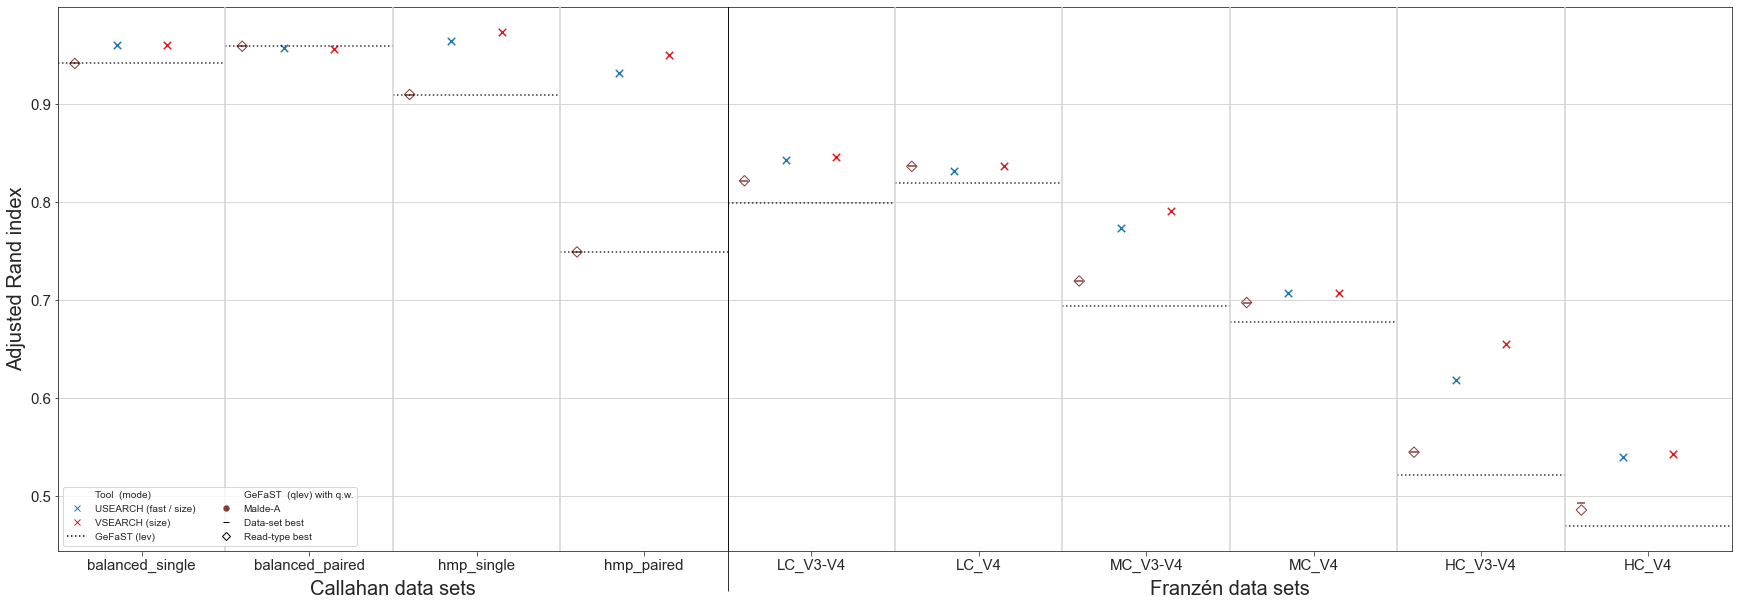

In [11]:
df = comparative_plot([('Callahan data sets', df_callahan_gefast_max_lvls, df_callahan_uvsearch_joined_max_avg,'callahan', ['balanced_single', 'balanced_paired', 'hmp_single', 'hmp_paired']), 
                       ('Franzén data sets', df_franzen_gefast_max_lvls, df_franzen_uvsearch_joined_max_avg, 'franzen', ['LC_V3-V4', 'LC_V4', 'MC_V3-V4', 'MC_V4', 'HC_V3-V4', 'HC_V4'])], 
                      'adjrandindex', (mode, qmode), select_metric = 'adjrandindex', qw_opts = [qw_option])
df.sort_values(by = ['qw_opt', 'data_set'])

Candidates for best choice based on maximum:

In [12]:
pd.Series([v.split(';')[0] for v in df['read_type_best']] + [v.split(';')[0] for v in df['data_set_best']]).value_counts()

v1 / linear / 0           10
muw / unboosted / none     7
v1 / mult / 50             1
v3 / mult / 100            1
v1 / mult / 100            1
dtype: int64

-- *Average clustering quality*

,data_set,qw_opt,lev_baseline,read_type_best,data_set_best
8,HC_V3-V4,ma,lev; 0.287985,v1 / linear / 0; +0.008871,v1 / linear / 0; +0.008871
9,HC_V4,ma,lev; 0.370216,v1 / linear / 0; +0.026550,v1 / linear / 0; +0.026550
4,LC_V3-V4,ma,lev; 0.387562,v1 / linear / 0; +0.006504,v1 / linear / 0; +0.006504
5,LC_V4,ma,lev; 0.732680,v1 / linear / 0; +0.020698,v3 / mult / 100; +0.020730
6,MC_V3-V4,ma,lev; 0.357186,v1 / linear / 0; +0.007931,v1 / linear / 0; +0.007931
7,MC_V4,ma,lev; 0.581453,v1 / linear / 0; +0.024146,v1 / linear / 0; +0.024146
1,balanced_paired,ma,lev; 0.930199,v1 / mult / 250; +0.001737,v3 / mult / 10; +0.001746
0,balanced_single,ma,lev; 0.915925,v3 / mult / 500; +0.002324,v1 / mult / 50; +0.002484
3,hmp_paired,ma,lev; 0.698473,v1 / mult / 250; +0.000290,v3 / mult / 1000; +0.000319
2,hmp_single,ma,lev; 0.748276,v3 / mult / 500; +0.011973,v1 / rootshift / 3; +0.016622


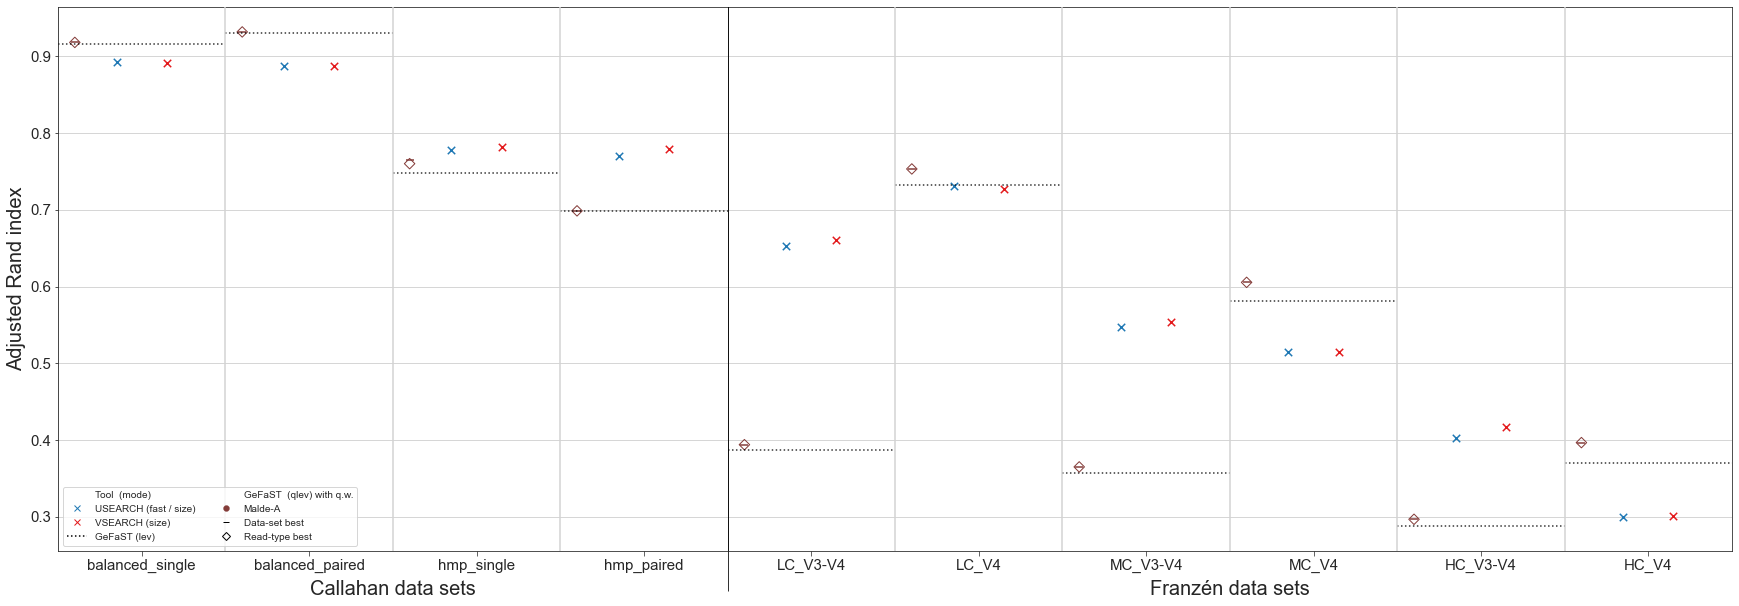

In [13]:
df = comparative_plot([('Callahan data sets', df_callahan_gefast_mean_lvls, df_callahan_uvsearch_joined_mean_avg,'callahan', ['balanced_single', 'balanced_paired', 'hmp_single', 'hmp_paired']), 
                      ('Franzén data sets', df_franzen_gefast_mean_lvls, df_franzen_uvsearch_joined_mean_avg, 'franzen', ['LC_V3-V4', 'LC_V4', 'MC_V3-V4', 'MC_V4', 'HC_V3-V4', 'HC_V4'])], 
                     'adjrandindex', (mode, qmode), select_metric = 'adjrandindex', qw_opts = [qw_option])
df.sort_values(by = ['qw_opt', 'data_set'])

Candidates for best choice based on average:

In [14]:
pd.Series([v.split(';')[0] for v in df['read_type_best']] + [v.split(';')[0] for v in df['data_set_best']]).value_counts()

v1 / linear / 0       11
v1 / mult / 250        2
v3 / mult / 500        2
v1 / mult / 50         1
v1 / rootshift / 3     1
v3 / mult / 100        1
v3 / mult / 1000       1
v3 / mult / 10         1
dtype: int64

-- *N-best average clustering quality*

,data_set,qw_opt,lev_baseline,read_type_best,data_set_best
8,HC_V3-V4,ma,lev; 0.480776,v1 / linear / 0; +0.017445,v1 / linear / 0; +0.017445
9,HC_V4,ma,lev; 0.437061,v1 / linear / 0; +0.022510,v1 / linear / 0; +0.022510
4,LC_V3-V4,ma,lev; 0.681617,v1 / linear / 0; +0.012891,v1 / linear / 0; +0.012891
5,LC_V4,ma,lev; 0.805443,v1 / linear / 0; +0.021548,v3 / mult / 100; +0.021601
6,MC_V3-V4,ma,lev; 0.614618,v1 / linear / 0; +0.015674,v1 / linear / 0; +0.015674
7,MC_V4,ma,lev; 0.649142,v1 / linear / 0; +0.023409,v1 / linear / 0; +0.023409
1,balanced_paired,ma,lev; 0.953554,muw / unboosted / none; -0.000838,v1 / mult / 50; -0.000838
0,balanced_single,ma,lev; 0.938556,v3 / rootshift / 3; -0.000238,v3 / rootshift / 3; -0.000238
3,hmp_paired,ma,lev; 0.729778,muw / unboosted / none; +0.000011,muw / unboosted / none; +0.000011
2,hmp_single,ma,lev; 0.832137,v3 / rootshift / 3; +0.000091,v3 / mult / 20; +0.000122


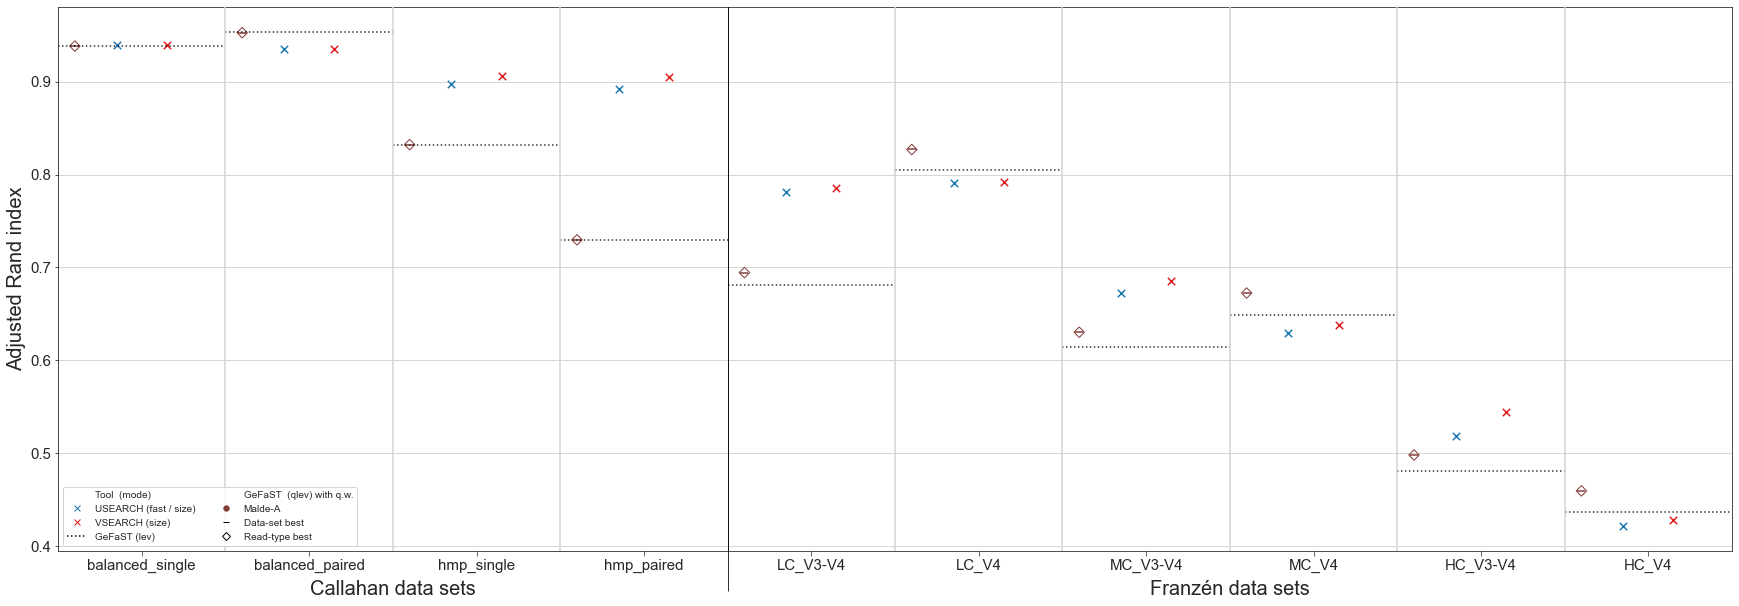

In [15]:
df = comparative_plot([('Callahan data sets', df_callahan_gefast_nbest_lvls, df_callahan_uvsearch_joined_nbest_avg,'callahan', ['balanced_single', 'balanced_paired', 'hmp_single', 'hmp_paired']), 
                      ('Franzén data sets', df_franzen_gefast_nbest_lvls, df_franzen_uvsearch_joined_nbest_avg, 'franzen', ['LC_V3-V4', 'LC_V4', 'MC_V3-V4', 'MC_V4', 'HC_V3-V4', 'HC_V4'])], 
                     'adjrandindex', (mode, qmode), select_metric = 'adjrandindex', qw_opts = [qw_option])
df.sort_values(by = ['qw_opt', 'data_set'])

Candidates for best choice based on N-best average:

In [16]:
pd.Series([v.split(';')[0] for v in df['read_type_best']] + [v.split(';')[0] for v in df['data_set_best']]).value_counts()

v1 / linear / 0           11
v3 / rootshift / 3         3
muw / unboosted / none     3
v3 / mult / 100            1
v1 / mult / 50             1
v3 / mult / 20             1
dtype: int64

Next, compare the performance of the candidates seen most often on the different data-set groups:

-- *Maximum clustering quality*

In [17]:
avg_diff_multiple([(df_franzen_gefast_joined_max_avg, [('V3-V4', ['LC_V3-V4', 'MC_V3-V4', 'HC_V3-V4']), ('V4', ['LC_V4', 'MC_V4', 'HC_V4'])], 'franzen'),
                   (df_callahan_gefast_joined_max_avg, [('paired', ['balanced_paired', 'hmp_paired']), ('single', ['balanced_single', 'hmp_single'])], 'callahan')], 
                  (mode, 'none', 'none', 'none', 'none'), 
                  [(qmode, 'v1', qw_option, 'linear', '0'),
                   (qmode, 'v3', qw_option, 'rootshift', '3'),
                   (qmode, 'v1', qw_option, 'mult', '50'),
                   (qmode, 'v3', qw_option, 'mult', '100'),
                   (qmode, best_ub, qw_option, 'unboosted', 'none')])

,data_group,qlev / v1 / ma / linear / 0,qlev / v3 / ma / rootshift / 3,qlev / v1 / ma / mult / 50,qlev / v3 / ma / mult / 100,qlev / mw / ma / unboosted / none
0,V3-V4,0.023920,0.001554,-0.002923,0.023842,0.001115
1,V4,0.017773,0.001707,0.010751,0.017711,0.001617
2,paired,-0.008506,0.000012,-0.000313,-0.000082,0.000012
3,single,0.000000,0.000000,0.000000,0.000000,0.000000


Based on maximum, `v1 / linear / 0` and `v3 / mult / 100` were the best overall but had a slight weakness on paired, where others like `muw` would be better.

-- *Average clustering quality*

In [18]:
avg_diff_multiple([(df_franzen_gefast_joined_mean_avg, [('V3-V4', ['LC_V3-V4', 'MC_V3-V4', 'HC_V3-V4']), ('V4', ['LC_V4', 'MC_V4', 'HC_V4'])], 'franzen'),
                   (df_callahan_gefast_joined_mean_avg, [('paired', ['balanced_paired', 'hmp_paired']), ('single', ['balanced_single', 'hmp_single'])], 'callahan')], 
                  (mode, 'none', 'none', 'none', 'none'), 
                  [(qmode, 'v1', qw_option, 'linear', '0'),
                   (qmode, 'v3', qw_option, 'mult', '100'),
                   (qmode, best_ub, qw_option, 'unboosted', 'none')])

,data_group,qlev / v1 / ma / linear / 0,qlev / v3 / ma / mult / 100,qlev / mw / ma / unboosted / none
0,V3-V4,0.007768,0.007713,0.000349
1,V4,0.023798,0.023390,0.002354
2,paired,-0.006380,0.000910,0.000938
3,single,0.000079,0.007106,0.002881


-- *N-best average clustering quality*

In [19]:
avg_diff_multiple([(df_franzen_gefast_joined_nbest_avg, [('V3-V4', ['LC_V3-V4', 'MC_V3-V4', 'HC_V3-V4']), ('V4', ['LC_V4', 'MC_V4', 'HC_V4'])], 'franzen'),
                   (df_callahan_gefast_joined_nbest_avg, [('paired', ['balanced_paired', 'hmp_paired']), ('single', ['balanced_single', 'hmp_single'])], 'callahan')], 
                  (mode, 'none', 'none', 'none', 'none'), 
                  [(qmode, 'v1', qw_option, 'linear', '0'),
                   (qmode, 'v3', qw_option, 'mult', '100'),
                   (qmode, best_ub, qw_option, 'unboosted', 'none')])

,data_group,qlev / v1 / ma / linear / 0,qlev / v3 / ma / mult / 100,qlev / mw / ma / unboosted / none
0,V3-V4,0.015337,0.015227,0.000724
1,V4,0.022489,0.022347,0.001606
2,paired,-0.008517,-0.000471,-0.000414
3,single,-0.004796,-0.000201,-0.000082


`v3 / mult / 100` is slightly more robust than `v1 / linear / 0` on Callahan data and very similar on Franzén data.

In [20]:
best_v = 'v3'
best_b = 'mult'
best_bp = '100'

**Comparison of quality metrics of the picked boosted and unboosted variant with the quality-unweighted mode**

-- *Maximum clustering quality*

In [21]:
for m in ['adjrandindex', 'precision', 'recall']:
    print('%s:' % rename_map[m])
    display(avg_diff_multiple([(df_franzen_gefast_joined_max_avg, [('V3-V4', ['LC_V3-V4', 'MC_V3-V4', 'HC_V3-V4']), ('V4', ['LC_V4', 'MC_V4', 'HC_V4'])], 'franzen'),
                               (df_callahan_gefast_joined_max_avg, [('paired', ['balanced_paired', 'hmp_paired']), ('single', ['balanced_single', 'hmp_single'])], 'callahan')], 
                              (mode, 'none', 'none', 'none', 'none'), [(qmode, best_v, qw_option, best_b, best_bp), (qmode, best_ub, qw_option, 'unboosted', 'none')], metric = m))

Adjusted Rand index:


,data_group,qlev / v3 / ma / mult / 100,qlev / mw / ma / unboosted / none
0,V3-V4,0.023842,0.001115
1,V4,0.017711,0.001617
2,paired,-0.000082,0.000012
3,single,0.000000,0.000000


Precision:


,data_group,qlev / v3 / ma / mult / 100,qlev / mw / ma / unboosted / none
0,V3-V4,0.020592,0.000874
1,V4,-0.000632,-0.001860
2,paired,0.000029,0.000016
3,single,0.000000,0.000000


Recall:


,data_group,qlev / v3 / ma / mult / 100,qlev / mw / ma / unboosted / none
0,V3-V4,0.001828,0.001278
1,V4,0.022774,0.005254
2,paired,-0.000052,0.000002
3,single,0.000000,0.000000


Improved ARI accompanied by higher recall and, on V3-V4, also a higher precision.
Overall, the boosted variant was better than unboosted.

-- *Average clustering quality*

In [22]:
for m in ['adjrandindex', 'precision', 'recall']:
    print('%s:' % rename_map[m])
    display(avg_diff_multiple([(df_franzen_gefast_joined_mean_avg, [('V3-V4', ['LC_V3-V4', 'MC_V3-V4', 'HC_V3-V4']), ('V4', ['LC_V4', 'MC_V4', 'HC_V4'])], 'franzen'),
                               (df_callahan_gefast_joined_mean_avg, [('paired', ['balanced_paired', 'hmp_paired']), ('single', ['balanced_single', 'hmp_single'])], 'callahan')], 
                              (mode, 'none', 'none', 'none', 'none'), [(qmode, best_v, qw_option, best_b, best_bp), (qmode, best_ub, qw_option, 'unboosted', 'none')], metric = m))

Adjusted Rand index:


,data_group,qlev / v3 / ma / mult / 100,qlev / mw / ma / unboosted / none
0,V3-V4,0.007713,0.000349
1,V4,0.023390,0.002354
2,paired,0.000910,0.000938
3,single,0.007106,0.002881


Precision:


,data_group,qlev / v3 / ma / mult / 100,qlev / mw / ma / unboosted / none
0,V3-V4,0.008419,0.000560
1,V4,0.023959,0.002506
2,paired,0.000964,0.000875
3,single,0.002666,0.001591


Recall:


,data_group,qlev / v3 / ma / mult / 100,qlev / mw / ma / unboosted / none
0,V3-V4,-0.000950,-0.000144
1,V4,-0.000559,-0.000001
2,paired,-0.000401,-0.000354
3,single,0.000758,0.000293


Slightly more robust in terms of ARI on all data categories.   
Accompanied by higher precision and lower recall compared to `original_lev`.

-- *N-best average clustering quality*

In [23]:
for m in ['adjrandindex', 'precision', 'recall']:
    print('%s:' % rename_map[m])
    display(avg_diff_multiple([(df_franzen_gefast_joined_nbest_avg, [('V3-V4', ['LC_V3-V4', 'MC_V3-V4', 'HC_V3-V4']), ('V4', ['LC_V4', 'MC_V4', 'HC_V4'])], 'franzen'),
                               (df_callahan_gefast_joined_nbest_avg, [('paired', ['balanced_paired', 'hmp_paired']), ('single', ['balanced_single', 'hmp_single'])], 'callahan')], 
                              (mode, 'none', 'none', 'none', 'none'), [(qmode, best_v, qw_option, best_b, best_bp), (qmode, best_ub, qw_option, 'unboosted', 'none')], metric = m))

Adjusted Rand index:


,data_group,qlev / v3 / ma / mult / 100,qlev / mw / ma / unboosted / none
0,V3-V4,0.015227,0.000724
1,V4,0.022347,0.001606
2,paired,-0.000471,-0.000414
3,single,-0.000201,-0.000082


Precision:


,data_group,qlev / v3 / ma / mult / 100,qlev / mw / ma / unboosted / none
0,V3-V4,0.015941,0.001098
1,V4,0.017542,0.001140
2,paired,0.000215,0.000174
3,single,0.000634,0.000525


Recall:


,data_group,qlev / v3 / ma / mult / 100,qlev / mw / ma / unboosted / none
0,V3-V4,-0.001726,-0.000251
1,V4,0.003709,0.000522
2,paired,-0.000873,-0.000823
3,single,-0.001058,-0.000748


Slightly more robust in terms of ARI on Franzén data.   
Accompanied by higher precision and lower recall compared to `original_lev`.

**Absolute and relative difference of picked boosted and unboosted variant to quality-unweighted mode (ARI)**

Below tables state the following values for both the boosted and unboosted variant: the clustering quality of the Levenshtein mode (`ref_val`), the clustering quality of the picked variant (`cmp_val`), the absolute difference between both (`abs_diff`), and the relative difference between both (`rel_diff`).   
For better readability, the two groups of columns separated by an additional column containing no values.

In [24]:
def show_detailed_diffs(portions, ref, cmps, metric = 'adjrandindex'):
    
    ref_mode, ref_v, ref_qw, ref_b, ref_bp = ref
    
    df_columns = ['data_group']
    for m, v, q, b, bp in cmps:
        df_columns.append('%s / %s / %s / %s / %s | ref_val' % (ref_mode, ref_v, ref_qw, ref_b, ref_bp))
        for s in ['cmp_val', 'abs_diff', 'rel_diff']: 
            df_columns.append('%s / %s / %s / %s / %s | %s' % (m, v, q, b, bp, s))
        df_columns.append('---')
    
    rows = []
    for df, data_set_groups, gt in portions:
        for (name, dsg) in data_set_groups:            
            ref_grp = df.loc[df['data_set'].isin(dsg) & (df['gt'] == gt) & (df['mode'] == ref_mode) & (df['v_opt'] == ref_v) & (df['qw_opt'] == ref_qw) & (df['b_opt'] == ref_b) & (df['b_param'] == ref_bp)]
            
            row = [name]
            for mode, v, qw, b, bp in cmps:
                cmp_grp = df.loc[df['data_set'].isin(dsg) & (df['gt'] == gt) & (df['mode'] == mode) & (df['v_opt'] == v) & (df['qw_opt'] == qw) & (df['b_opt'] == b) & (df['b_param'] == bp)]
                
                row.append(ref_grp[metric].mean())
                row.append(cmp_grp[metric].mean())
                row.append(cmp_grp[metric].mean() - ref_grp[metric].mean())
                row.append(cmp_grp[metric].mean() / ref_grp[metric].mean() - 1.0)
                row.append('---')
            
            rows.append(row)
            
    return pd.DataFrame(rows, columns = df_columns)

-- *Maximum clustering quality*

In [25]:
show_detailed_diffs([(df_franzen_gefast_joined_max_avg, [('LC_V3-V4', ['LC_V3-V4']), ('MC_V3-V4', ['MC_V3-V4']), ('HC_V3-V4', ['HC_V3-V4']), ('V3-V4', ['LC_V3-V4', 'MC_V3-V4', 'HC_V3-V4']), ('LC_V4', ['LC_V4']), ('MC_V4', ['MC_V4']), ('HC_V4', ['HC_V4']), ('V4', ['LC_V4', 'MC_V4', 'HC_V4']), ('Franzén', ['LC_V3-V4', 'LC_V4', 'MC_V3-V4', 'MC_V4', 'HC_V3-V4', 'HC_V4'])], 'franzen'),
                     (df_callahan_gefast_joined_max_avg, [('balanced_paired', ['balanced_paired']), ('hmp_paired', ['hmp_paired']), ('paired', ['balanced_paired', 'hmp_paired']), ('balanced_single', ['balanced_single']), ('hmp_single', ['hmp_single']), ('single', ['balanced_single', 'hmp_single']), ('Callahan', ['balanced_paired', 'balanced_single', 'hmp_paired', 'hmp_single'])], 'callahan')], 
                    (mode, 'none', 'none', 'none', 'none'), [(qmode, best_v, qw_option, best_b, best_bp), (qmode, best_ub, qw_option, 'unboosted', 'none')], metric = 'adjrandindex')

,data_group,lev / none / none / none / none | ref_val,qlev / v3 / ma / mult / 100 | cmp_val,qlev / v3 / ma / mult / 100 | abs_diff,qlev / v3 / ma / mult / 100 | rel_diff,---,lev / none / none / none / none | ref_val,qlev / mw / ma / unboosted / none | cmp_val,qlev / mw / ma / unboosted / none | abs_diff,qlev / mw / ma / unboosted / none | rel_diff,---
0,LC_V3-V4,0.799117,0.821699,0.022581,0.028258,---,0.799117,0.799444,0.000326,0.000408,---
1,MC_V3-V4,0.693649,0.719436,0.025788,0.037177,---,0.693649,0.695671,0.002022,0.002915,---
2,HC_V3-V4,0.521358,0.544514,0.023156,0.044415,---,0.521358,0.522356,0.000998,0.001914,---
3,V3-V4,0.671375,0.695216,0.023842,0.035512,---,0.671375,0.672490,0.001115,0.001661,---
4,LC_V4,0.818930,0.836471,0.017542,0.021420,---,0.818930,0.820620,0.001690,0.002064,---
5,MC_V4,0.677960,0.697179,0.019219,0.028348,---,0.677960,0.679595,0.001635,0.002411,---
6,HC_V4,0.469341,0.485714,0.016372,0.034883,---,0.469341,0.470868,0.001527,0.003253,---
7,V4,0.655411,0.673121,0.017711,0.027022,---,0.655411,0.657028,0.001617,0.002468,---
8,Franzén,0.663393,0.684169,0.020776,0.031318,---,0.663393,0.664759,0.001366,0.002060,---
9,balanced_paired,0.958953,0.958948,-0.000006,-0.000006,---,0.958953,0.958978,0.000025,0.000026,---


-- *Average clustering quality*

In [26]:
show_detailed_diffs([(df_franzen_gefast_joined_mean_avg, [('LC_V3-V4', ['LC_V3-V4']), ('MC_V3-V4', ['MC_V3-V4']), ('HC_V3-V4', ['HC_V3-V4']), ('V3-V4', ['LC_V3-V4', 'MC_V3-V4', 'HC_V3-V4']), ('LC_V4', ['LC_V4']), ('MC_V4', ['MC_V4']), ('HC_V4', ['HC_V4']), ('V4', ['LC_V4', 'MC_V4', 'HC_V4']), ('Franzén', ['LC_V3-V4', 'LC_V4', 'MC_V3-V4', 'MC_V4', 'HC_V3-V4', 'HC_V4'])], 'franzen'),
                     (df_callahan_gefast_joined_mean_avg, [('balanced_paired', ['balanced_paired']), ('hmp_paired', ['hmp_paired']), ('paired', ['balanced_paired', 'hmp_paired']), ('balanced_single', ['balanced_single']), ('hmp_single', ['hmp_single']), ('single', ['balanced_single', 'hmp_single']), ('Callahan', ['balanced_paired', 'balanced_single', 'hmp_paired', 'hmp_single'])], 'callahan')], 
                    (mode, 'none', 'none', 'none', 'none'), [(qmode, best_v, qw_option, best_b, best_bp), (qmode, best_ub, qw_option, 'unboosted', 'none')], metric = 'adjrandindex')

,data_group,lev / none / none / none / none | ref_val,qlev / v3 / ma / mult / 100 | cmp_val,qlev / v3 / ma / mult / 100 | abs_diff,qlev / v3 / ma / mult / 100 | rel_diff,---,lev / none / none / none / none | ref_val,qlev / mw / ma / unboosted / none | cmp_val,qlev / mw / ma / unboosted / none | abs_diff,qlev / mw / ma / unboosted / none | rel_diff,---
0,LC_V3-V4,0.387562,0.394065,0.006504,0.016781,---,0.387562,0.387664,0.000102,0.000263,---
1,MC_V3-V4,0.357186,0.365056,0.007870,0.022034,---,0.357186,0.357608,0.000422,0.001182,---
2,HC_V3-V4,0.287985,0.296751,0.008767,0.030441,---,0.287985,0.288509,0.000524,0.001821,---
3,V3-V4,0.344244,0.351957,0.007713,0.022407,---,0.344244,0.344593,0.000349,0.001015,---
4,LC_V4,0.732680,0.753410,0.020730,0.028293,---,0.732680,0.733983,0.001303,0.001779,---
5,MC_V4,0.581453,0.605211,0.023758,0.040859,---,0.581453,0.583432,0.001979,0.003404,---
6,HC_V4,0.370216,0.395898,0.025682,0.069370,---,0.370216,0.373997,0.003781,0.010212,---
7,V4,0.561450,0.584839,0.023390,0.041660,---,0.561450,0.563804,0.002354,0.004193,---
8,Franzén,0.452847,0.468398,0.015552,0.034342,---,0.452847,0.454199,0.001352,0.002985,---
9,balanced_paired,0.930199,0.931925,0.001725,0.001855,---,0.930199,0.931944,0.001745,0.001876,---


-- *N-best average clustering quality*

In [27]:
show_detailed_diffs([(df_franzen_gefast_joined_nbest_avg, [('LC_V3-V4', ['LC_V3-V4']), ('MC_V3-V4', ['MC_V3-V4']), ('HC_V3-V4', ['HC_V3-V4']), ('V3-V4', ['LC_V3-V4', 'MC_V3-V4', 'HC_V3-V4']), ('LC_V4', ['LC_V4']), ('MC_V4', ['MC_V4']), ('HC_V4', ['HC_V4']), ('V4', ['LC_V4', 'MC_V4', 'HC_V4']), ('Franzén', ['LC_V3-V4', 'LC_V4', 'MC_V3-V4', 'MC_V4', 'HC_V3-V4', 'HC_V4'])], 'franzen'),
                     (df_callahan_gefast_joined_nbest_avg, [('balanced_paired', ['balanced_paired']), ('hmp_paired', ['hmp_paired']), ('paired', ['balanced_paired', 'hmp_paired']), ('balanced_single', ['balanced_single']), ('hmp_single', ['hmp_single']), ('single', ['balanced_single', 'hmp_single']), ('Callahan', ['balanced_paired', 'balanced_single', 'hmp_paired', 'hmp_single'])], 'callahan')], 
                    (mode, 'none', 'none', 'none', 'none'), [(qmode, best_v, qw_option, best_b, best_bp), (qmode, best_ub, qw_option, 'unboosted', 'none')], metric = 'adjrandindex')

,data_group,lev / none / none / none / none | ref_val,qlev / v3 / ma / mult / 100 | cmp_val,qlev / v3 / ma / mult / 100 | abs_diff,qlev / v3 / ma / mult / 100 | rel_diff,---,lev / none / none / none / none | ref_val,qlev / mw / ma / unboosted / none | cmp_val,qlev / mw / ma / unboosted / none | abs_diff,qlev / mw / ma / unboosted / none | rel_diff,---
0,LC_V3-V4,0.681617,0.694508,0.012891,0.018912,---,0.681617,0.681821,0.000204,0.000299,---
1,MC_V3-V4,0.614618,0.630170,0.015552,0.025304,---,0.614618,0.615499,0.000881,0.001434,---
2,HC_V3-V4,0.480776,0.498015,0.017239,0.035857,---,0.480776,0.481863,0.001087,0.002261,---
3,V3-V4,0.592337,0.607564,0.015227,0.025707,---,0.592337,0.593061,0.000724,0.001222,---
4,LC_V4,0.805443,0.827045,0.021601,0.026819,---,0.805443,0.806424,0.000980,0.001217,---
5,MC_V4,0.649142,0.672372,0.023230,0.035786,---,0.649142,0.650547,0.001405,0.002164,---
6,HC_V4,0.437061,0.459272,0.022211,0.050819,---,0.437061,0.439495,0.002434,0.005568,---
7,V4,0.630549,0.652896,0.022347,0.035441,---,0.630549,0.632155,0.001606,0.002547,---
8,Franzén,0.611443,0.630230,0.018787,0.030726,---,0.611443,0.612608,0.001165,0.001906,---
9,balanced_paired,0.953554,0.952686,-0.000868,-0.000911,---,0.953554,0.952716,-0.000838,-0.000879,---


**Overview of the clustering quality of the picked variant compared to the other variants**

In the following, plots each vertical line corresponds to a group of variants using the same boosting function, boosting type (inner or outer), depicting the range of values of the quality metrics covered by varying the boosting parameter.   
The cross marks the clustering quality of the picked variant.

In [28]:
def overview_plot(portions, modes, metric, 
                  qw_opt, pick,
                  v_opt_groups = [('Unweighted matches', 'muw', ['v2', 'v4']), ('Weighted matches', 'mw', ['v1', 'v3'])], 
                  leg_positions = [(1, 0, 'best')], fs = (40, 20), plot_file = None):
    mode, qmode = modes
    pick_v, pick_b, pick_bp = pick

    colour_palette = sb.color_palette('Paired')
    colours = dict((v, colour_palette[i]) for i, v in  enumerate('%s_%s' % (bf, io) for bf in ['linear', 'mult', 'root', 'rootshift'] for io in ['inner', 'outer']))
    colours['ref'] = 'black'
    colours['pick'] = colour_palette[9]
    markers = {'pick': 'x', 'border': '_'}
    marker_size = 80
    vwidth = 5

    label_map = {'precision': 'Precision', 'recall': 'Recall', 'adjrandindex': 'Adjusted Rand index', 
                 'c': 'Clement', 'ca': 'Converge-A', 'cb': 'Converge-B', 'f': 'Frith',
                 'ka': 'Kim-A', 'kb': 'Kim-B', 'ma': 'Malde-A', 'mb': 'Malde-B', 'mc': 'Malde-C'}
    xticklabel_size = 25
    yticklabel_size = 25
    xlabel_size = 30
    ylabel_size = 30
    title_size = 35
    leg_size = 16
    
    width = 0.7
    start_val = -0.325
    b_step = 0.2
    v_step = 0.05

    sb.set_style('white')
    fig, axes = plt.subplots(nrows = len(portions), ncols = len(v_opt_groups), figsize = fs, sharey = 'row')


    for i, (name, dfg, data) in enumerate(portions):      
        for j, (opt_name, ub_opt, v_opts) in enumerate(v_opt_groups):

            if len(portions) > 1 and len(v_opt_groups) > 1:
                ax = axes[i][j]
            elif len(portions) > 1:
                ax = axes[i]
            elif len(v_opt_groups) > 1:
                ax = axes[j]
            else:
                ax = axes

            data_sets = sorted(dfg['data_set'].unique()) if data == 'sorted' else data

            legend_markers = []
            legend_labels = []

            leg_cols = 2
            
            # Boosting functions and position (colours)
            legend_markers.append(plt.Line2D([0,0],[0,0], marker = '', mew = 0.3, linestyle = ''))
            legend_labels.append('Boosting function (type)')
            for bf in ['linear', 'mult', 'root', 'rootshift']:
                for io in ['inner', 'outer']:
                    legend_markers.append(plt.Line2D([0,0],[0,0], markeredgecolor = colours['%s_%s' % (bf, io)], marker = 'o', markerfacecolor = colours['%s_%s' % (bf, io)], mew = 0.3, linestyle = ''))
                    legend_labels.append('%s (%s)' % (bf, io))

            # Reference values
            legend_markers.append(plt.Line2D([0,0],[0,0], marker = '', mew = 0.3, linestyle = ''))
            legend_labels.append('Reference values')
            legend_markers.append(plt.Line2D([0,0],[1,0], marker = '', color = 'black', mew = 0.3, linestyle = '--'))
            legend_labels.append('quality-unweighted mode (%s)' % mode)
            legend_markers.append(plt.Line2D([0,0],[1,0], marker = '', color = 'black', mew = 0.3, linestyle = ':'))
            legend_labels.append('unboosted')
            legend_markers.append(plt.Line2D([0,0],[0,0], marker = markers['pick'], markeredgecolor = colours['pick'], markerfacecolor = colours['pick'], linestyle = ''))
            legend_labels.append('%s / %s / %s' % (pick_v, pick_b, pick_bp))
            
            for _ in range(0, 9 - 4):
                legend_markers.append(plt.Line2D([0,0],[0,0], marker = '', mew = 0.3, linestyle = ''))
                legend_labels.append('')


            for d, ds in enumerate(data_sets):
                
                    
                ax.hlines(y = dfg.loc[(dfg['mode'] == mode) & (dfg['data_set'] == ds), metric].iloc[0], xmin = d - 0.5, xmax = d + 0.5, color = colours['ref'], linestyle = '--', alpha = 0.6)
                
                df_ub = dfg.loc[(dfg['mode'] == qmode) & (dfg['data_set'] == ds) & (dfg['v_opt'] == ub_opt) & (dfg['qw_opt'] == qw_opt)]
                ax.hlines(y = df_ub[metric].iloc[0], xmin = d - 0.5, xmax = d + 0.5, colors = colours['ref'], linestyle = ':', alpha = 0.8)   
                
                df_pick = dfg.loc[(dfg['mode'] == qmode) & (dfg['data_set'] == ds) & (dfg['v_opt'] == pick_v) & (dfg['qw_opt'] == qw_opt) & (dfg['b_opt'] == pick_b) & (dfg['b_param'] == pick_bp)]
                ax.scatter(d, df_pick[metric].iloc[0], color = colours['pick'], marker = markers['pick'], s = marker_size)
                
                for k, v_opt in enumerate(v_opts):
                    io_val = 'inner' if v_opt in ['v1', 'v2'] else 'outer'
                    
                    x_values = []
                    min_values = []
                    max_values = []
                    colour_values = []

                    df_qw = dfg.loc[(dfg['mode'] == qmode) & (dfg['data_set'] == ds) & (dfg['v_opt'] == v_opt) & (dfg['qw_opt'] == qw_opt)]

                    for l, (b_opt, grp) in enumerate(df_qw.groupby(by = 'b_opt')):
                        x_val = d + start_val + b_step * l + v_step * k #+ 0.03*d
                        x_values.append(x_val)
                        min_values.append(grp[metric].min())
                        max_values.append(grp[metric].max())
                        colour_values.append(colours['%s_%s' % (b_opt, io_val)])
                    ax.vlines(x = x_values, ymin = min_values, ymax = max_values, colors = colour_values, linewidth = vwidth)
                    ax.scatter(x_values, min_values, color = colour_values, marker = markers['border'], s = marker_size)
                    ax.scatter(x_values, max_values, color = colour_values, marker = markers['border'], s = marker_size)



            xlabel = 'Data set'
            xticks = range(0, len(data_sets))
            xtick_labels = data_sets

            ax.set_xticks(xticks, minor = True)
            ax.set_xticks([x + 0.5 for x in xticks[:-1]], minor = False)

            ax.set_xticklabels(xtick_labels, fontsize = xticklabel_size, minor = True)
            ax.set_xticklabels('', minor = False)

            ax.tick_params(axis = 'x', which = 'minor', direction = 'out', length = 5, color = 'black')        
            ax.tick_params(which = 'major', left = (j == 0))
            ax.tick_params(which = 'minor', bottom = True)
            ax.tick_params(axis = 'y', labelsize = yticklabel_size)

            ax.set_xlim((xticks[0] - 0.5, xticks[-1] + 0.5))

            ax.grid(True)

            if i == (len(portions) - 1):
                ax.set_xlabel(xlabel, fontsize = xlabel_size)
            if j == 0:
                ax.set_ylabel('%s\n\n%s' % (name, label_map[metric]), fontsize = ylabel_size)

            if i == 0:
                ax.set_title(opt_name, fontsize = title_size)


            for leg_row, leg_col, leg_loc in leg_positions:
                if leg_row == i and leg_col == j:
                    ax.legend(legend_markers, legend_labels, fontsize = leg_size, markerscale = 1.5, ncol = leg_cols, loc = leg_loc)

            
        
    plt.subplots_adjust(wspace = 0.1)

    if plot_file is not None:
        plt.savefig(plot_file, format = 'pdf', dpi = 1200, bbox_inches = 'tight')

-- *Maximum clustering quality*

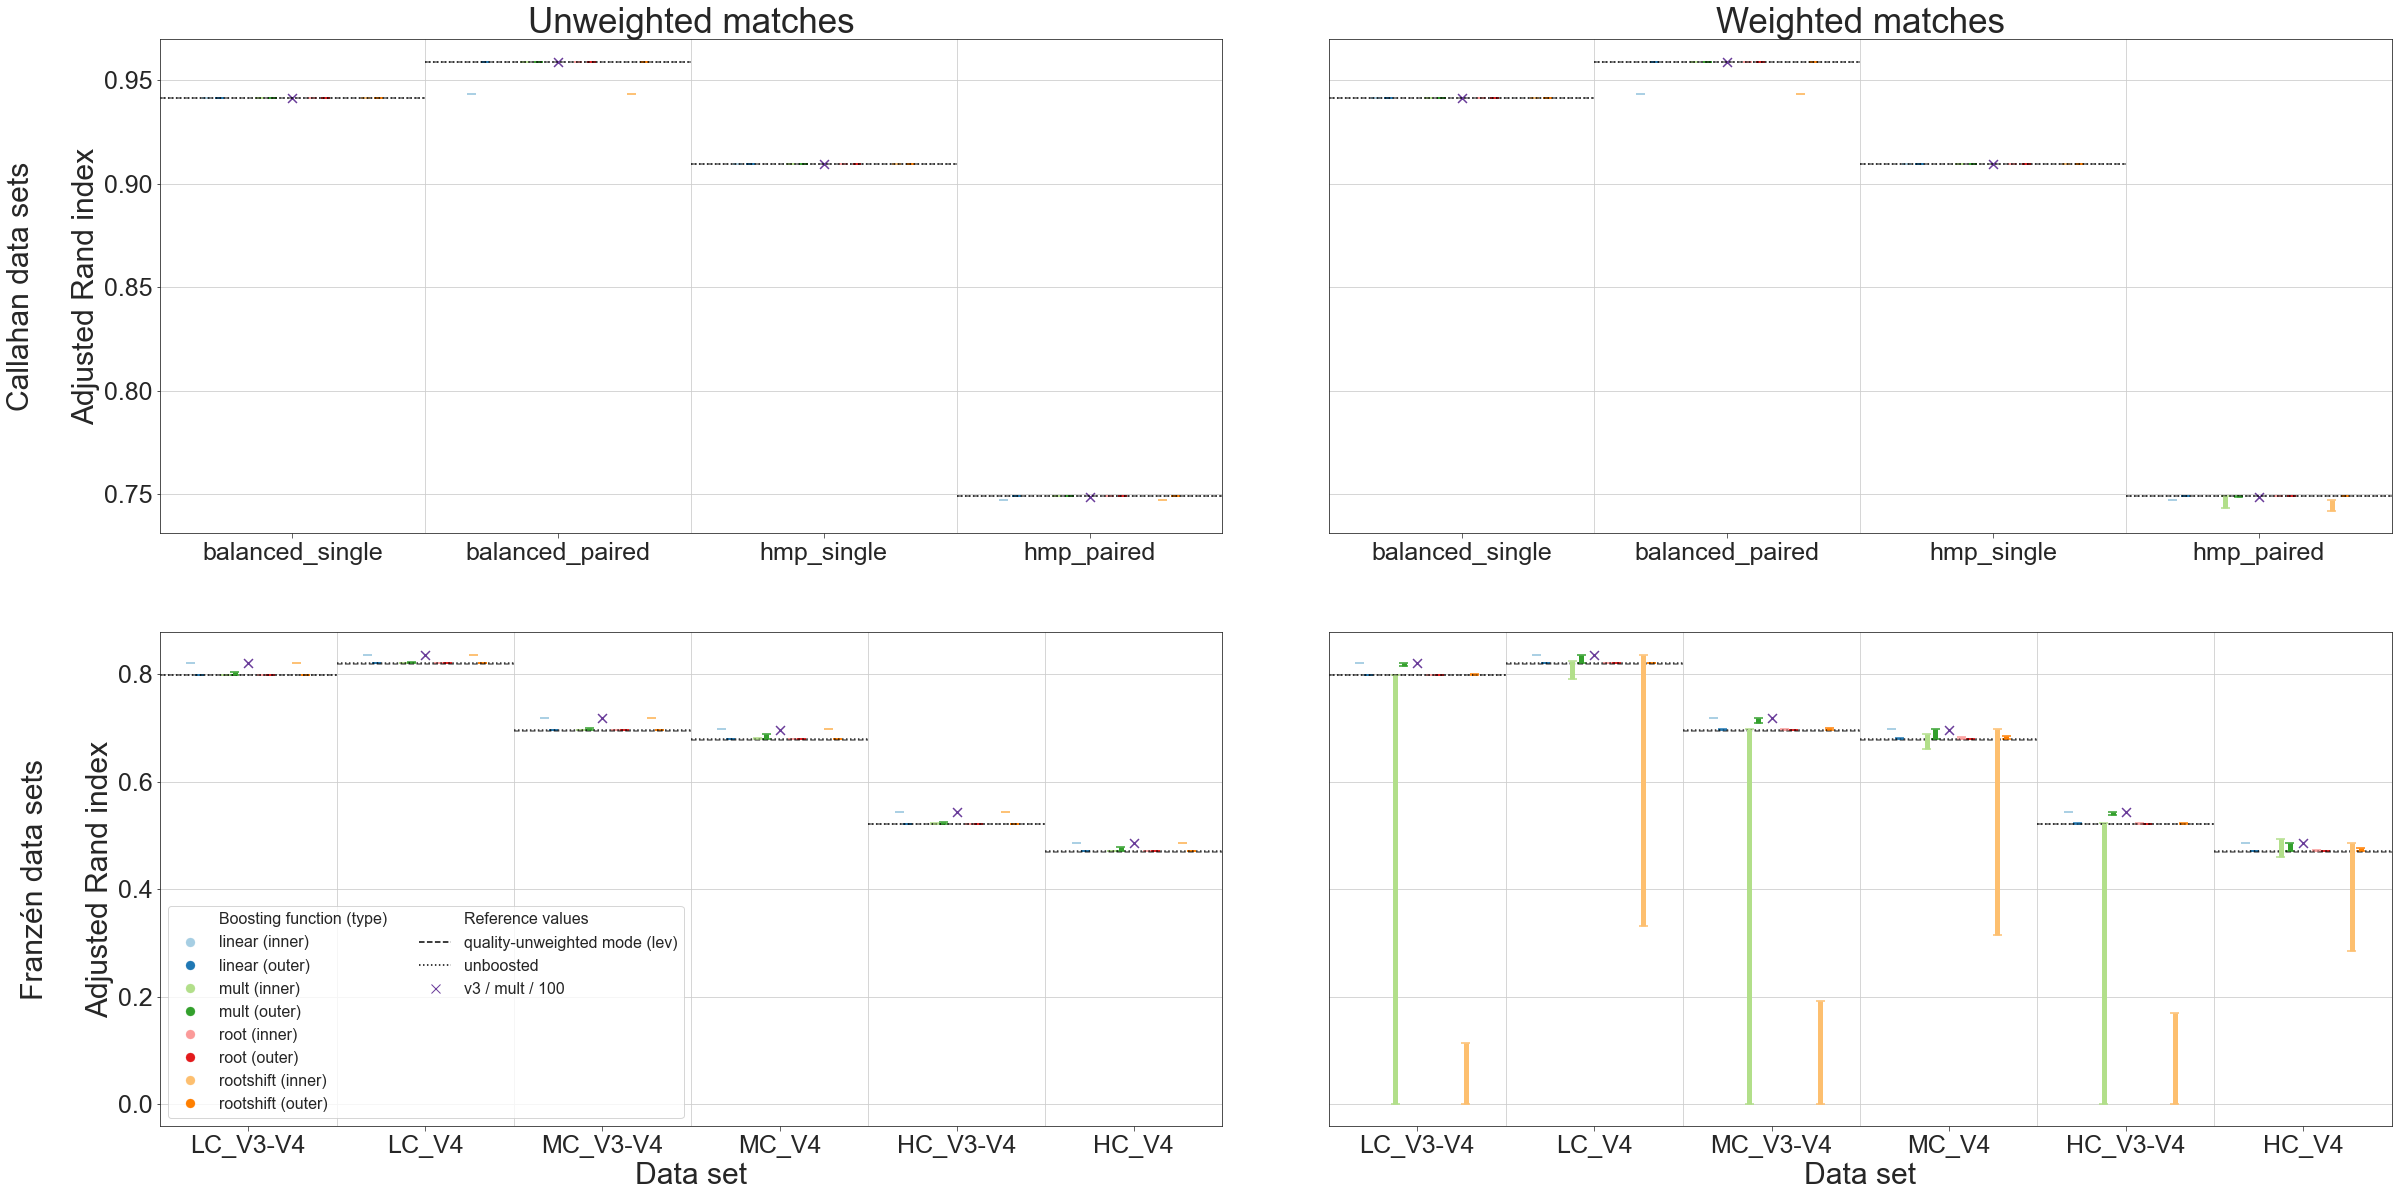

In [29]:
portions = [('Callahan data sets', df_callahan_gefast_joined_max_avg, ['balanced_single', 'balanced_paired', 'hmp_single', 'hmp_paired']), 
            ('Franzén data sets', df_franzen_gefast_joined_max_avg, ['LC_V3-V4', 'LC_V4', 'MC_V3-V4', 'MC_V4', 'HC_V3-V4', 'HC_V4'])]
modes = (mode, qmode)
metric = 'adjrandindex'
overview_plot(portions, modes, metric, qw_option, (best_v, best_b, best_bp))

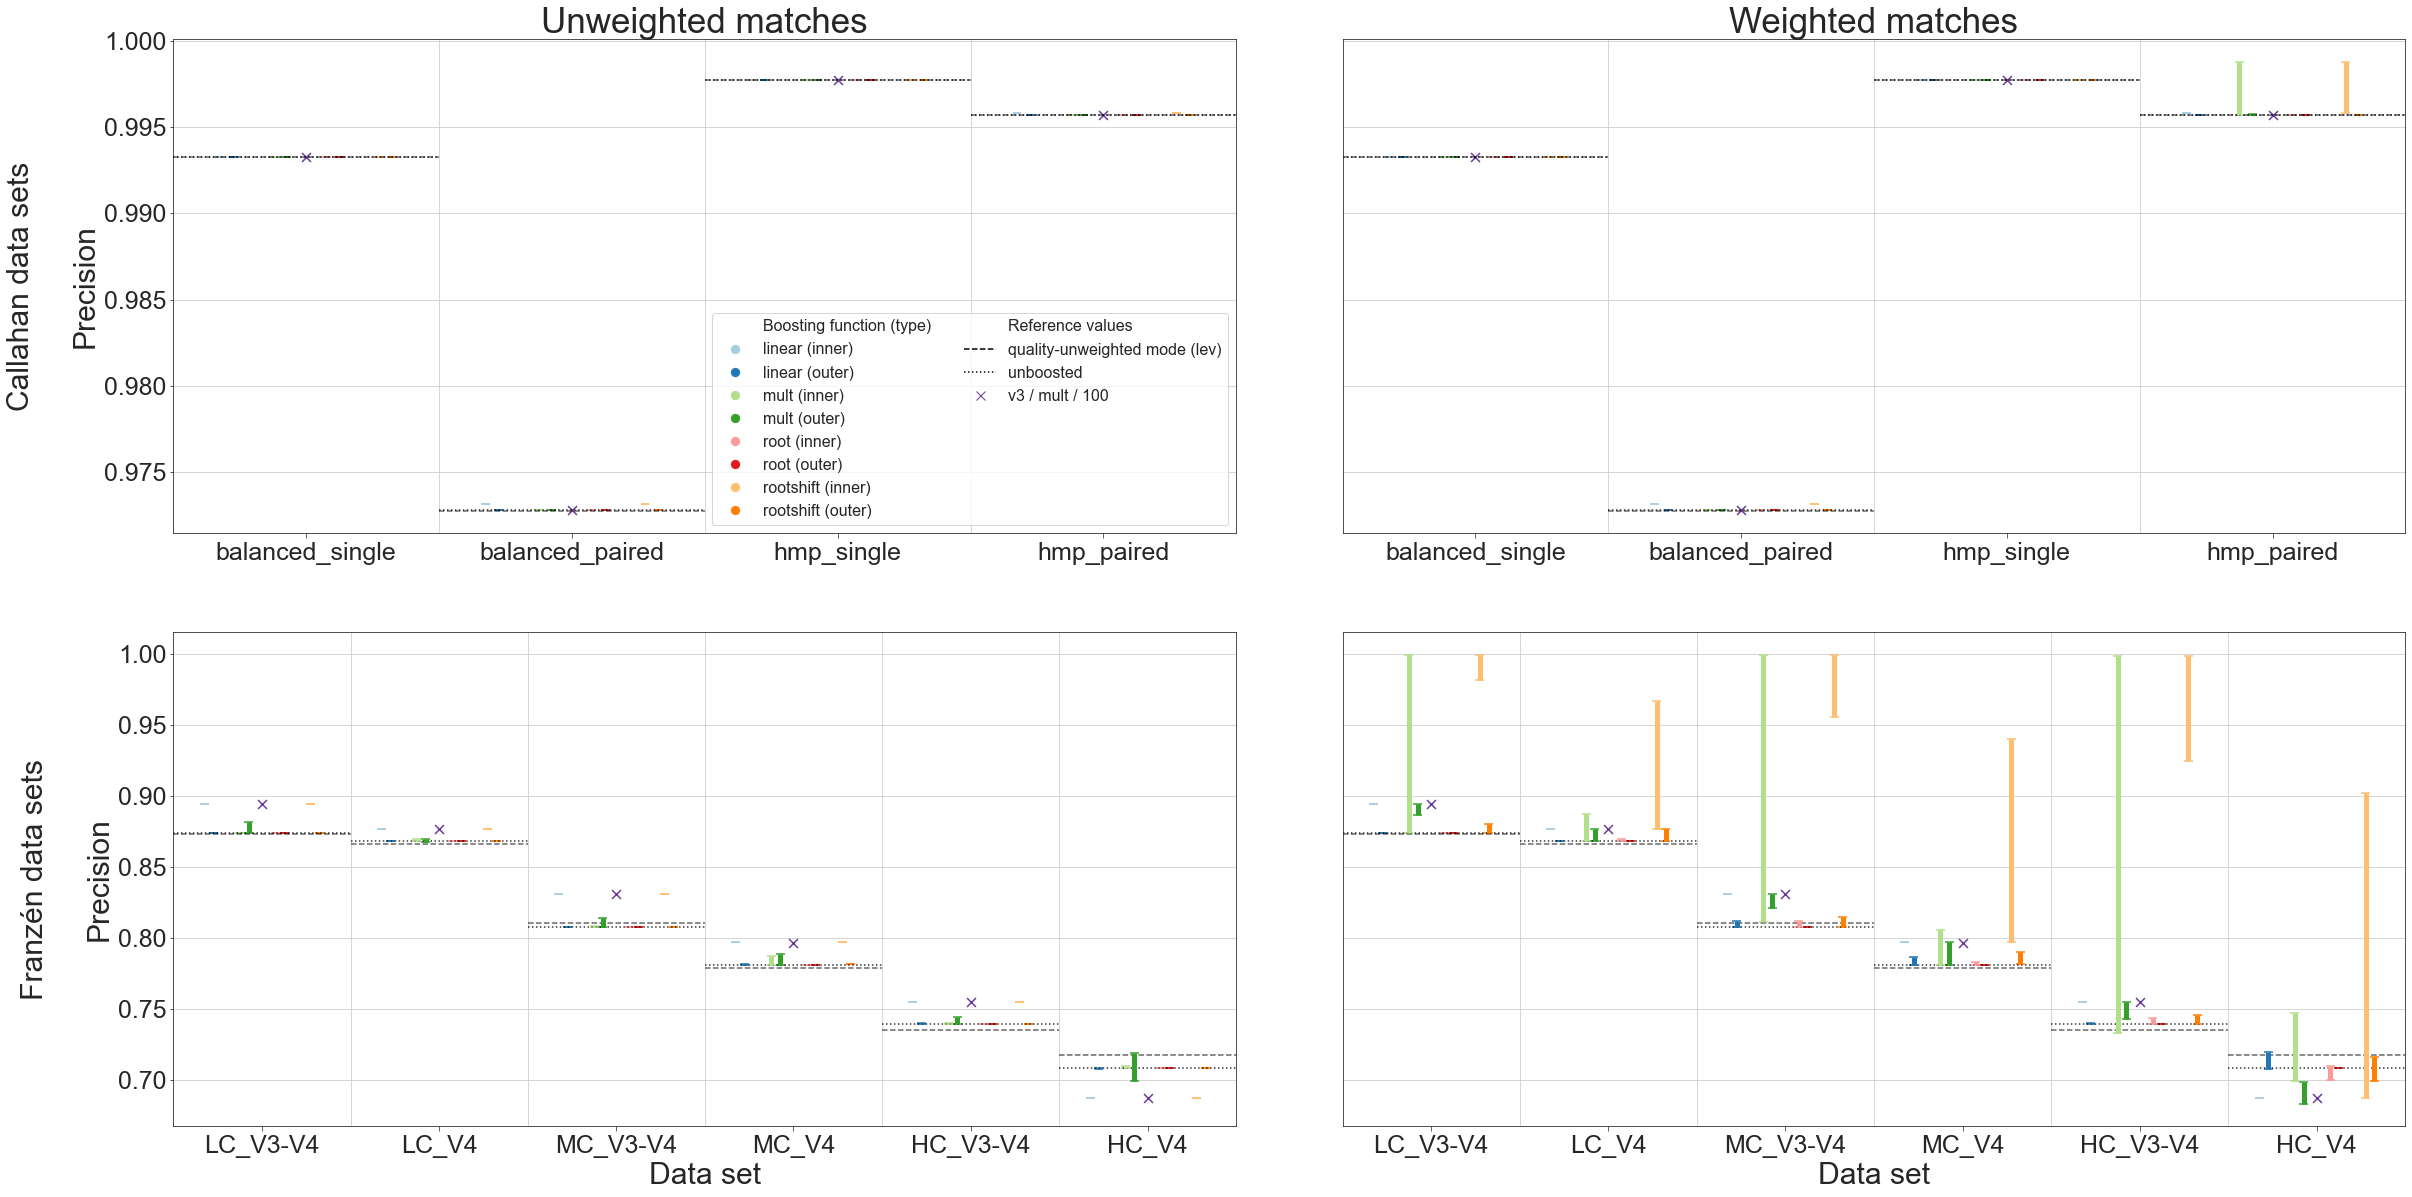

In [30]:
portions = [('Callahan data sets', df_callahan_gefast_joined_max_avg, ['balanced_single', 'balanced_paired', 'hmp_single', 'hmp_paired']), 
            ('Franzén data sets', df_franzen_gefast_joined_max_avg, ['LC_V3-V4', 'LC_V4', 'MC_V3-V4', 'MC_V4', 'HC_V3-V4', 'HC_V4'])]
modes = (mode, qmode)
metric = 'precision'
overview_plot(portions, modes, metric, qw_option, (best_v, best_b, best_bp), leg_positions = [(0, 0, 'best')])

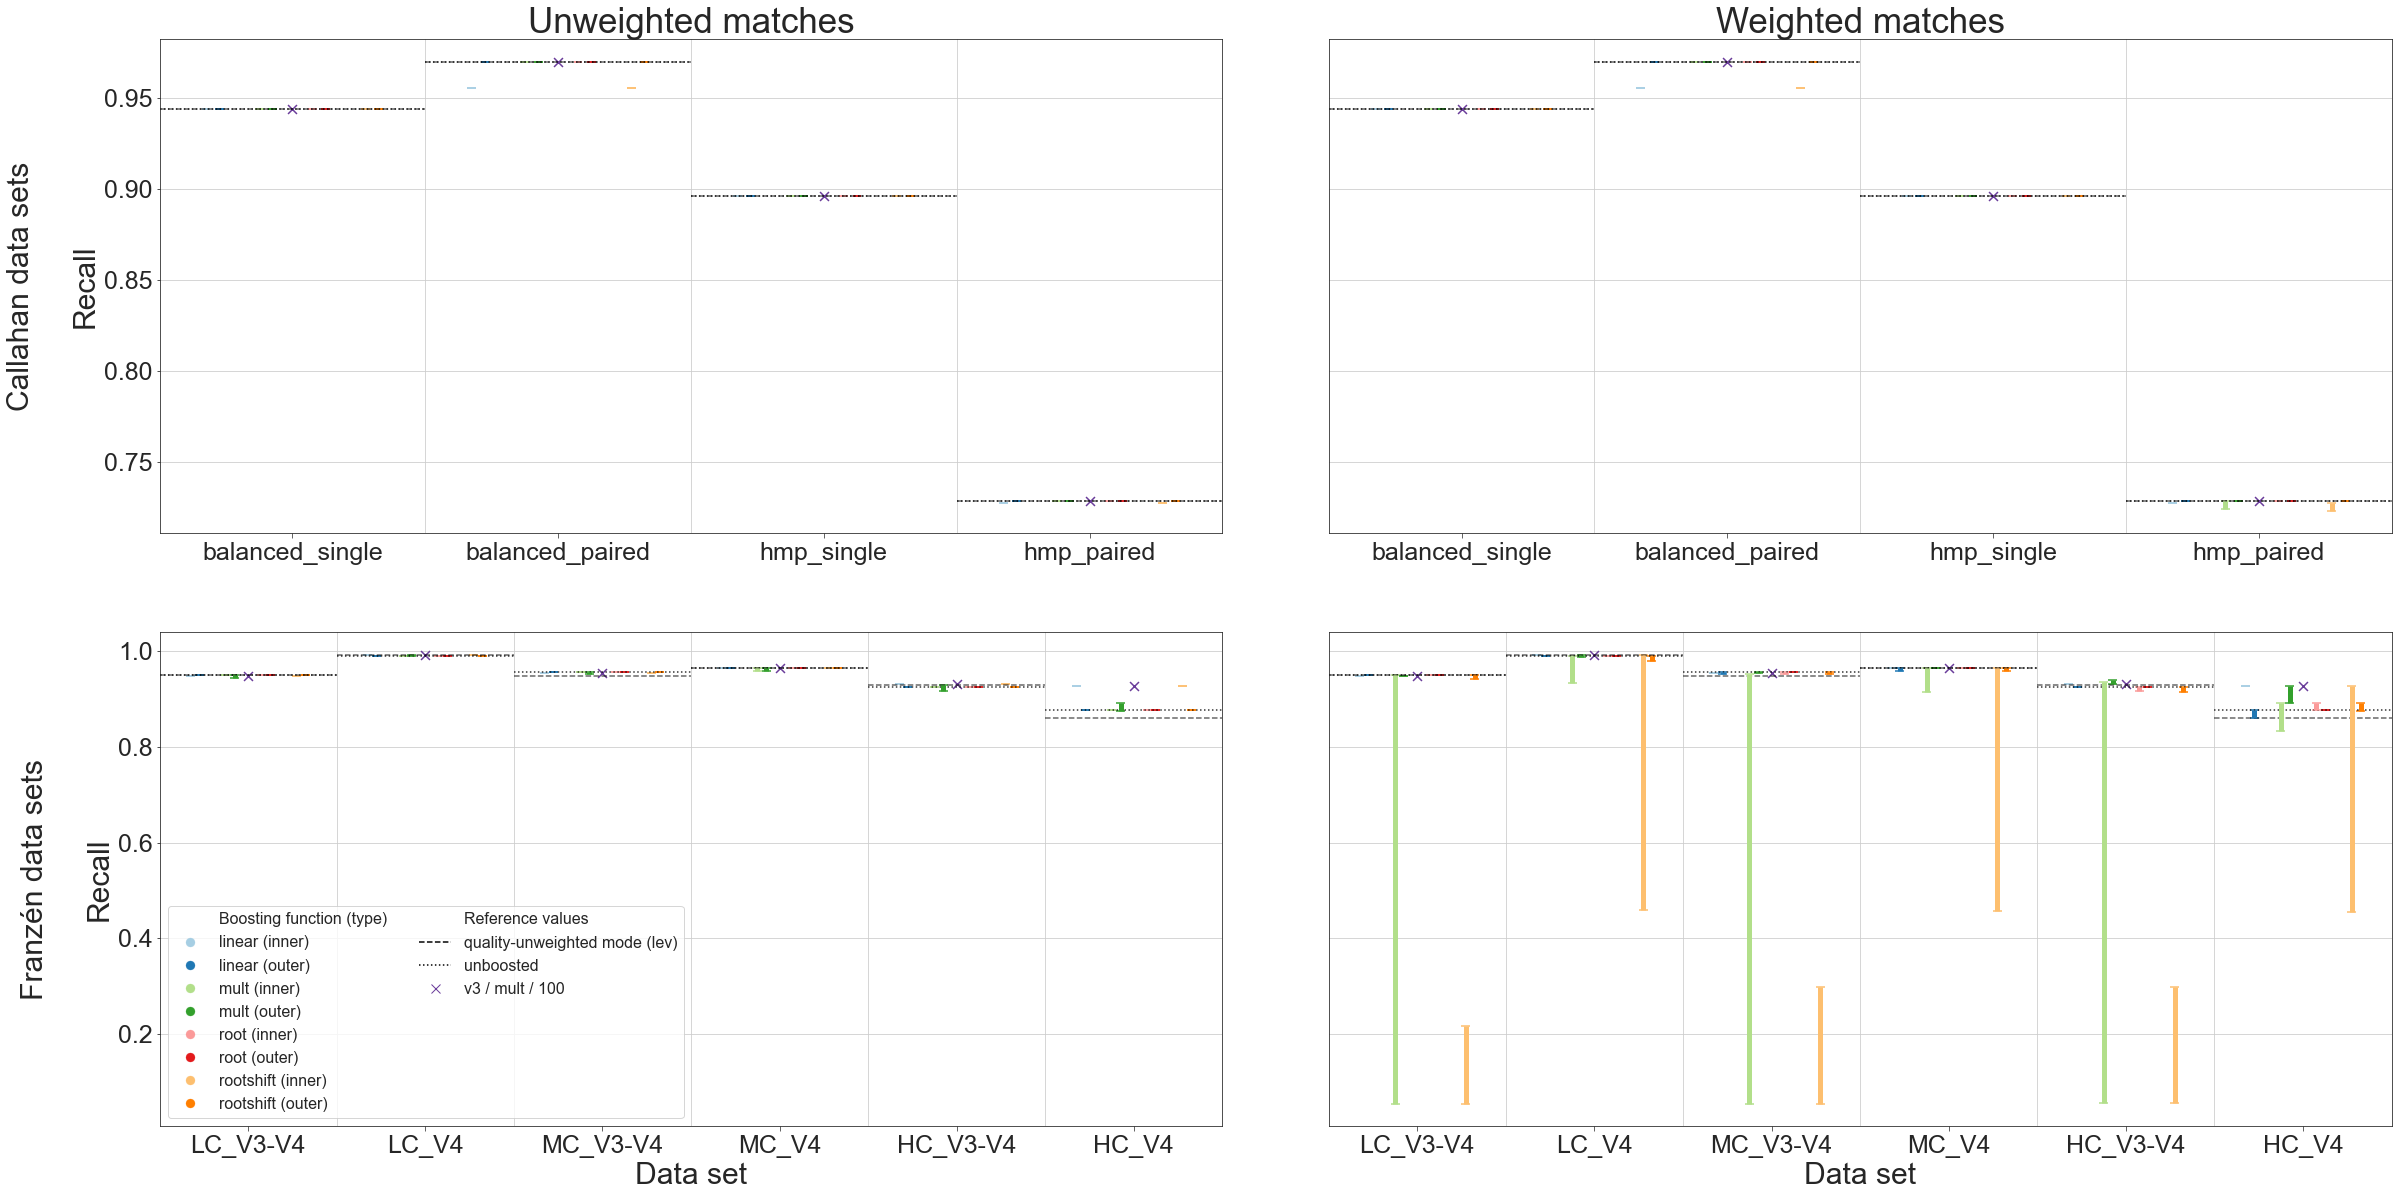

In [31]:
portions = [('Callahan data sets', df_callahan_gefast_joined_max_avg, ['balanced_single', 'balanced_paired', 'hmp_single', 'hmp_paired']), 
            ('Franzén data sets', df_franzen_gefast_joined_max_avg, ['LC_V3-V4', 'LC_V4', 'MC_V3-V4', 'MC_V4', 'HC_V3-V4', 'HC_V4'])]
modes = (mode, qmode)
metric = 'recall'
overview_plot(portions, modes, metric, qw_option, (best_v, best_b, best_bp))

Linear and rootshift (inner boosting) as well as mult (outer boosting) attained the largest improvements on Franzén data, due to a usually increased precision and an at least stable recall.   
Linear and rootshift, however, had some problems on `balanced_paired`.

-- *Average clustering quality*

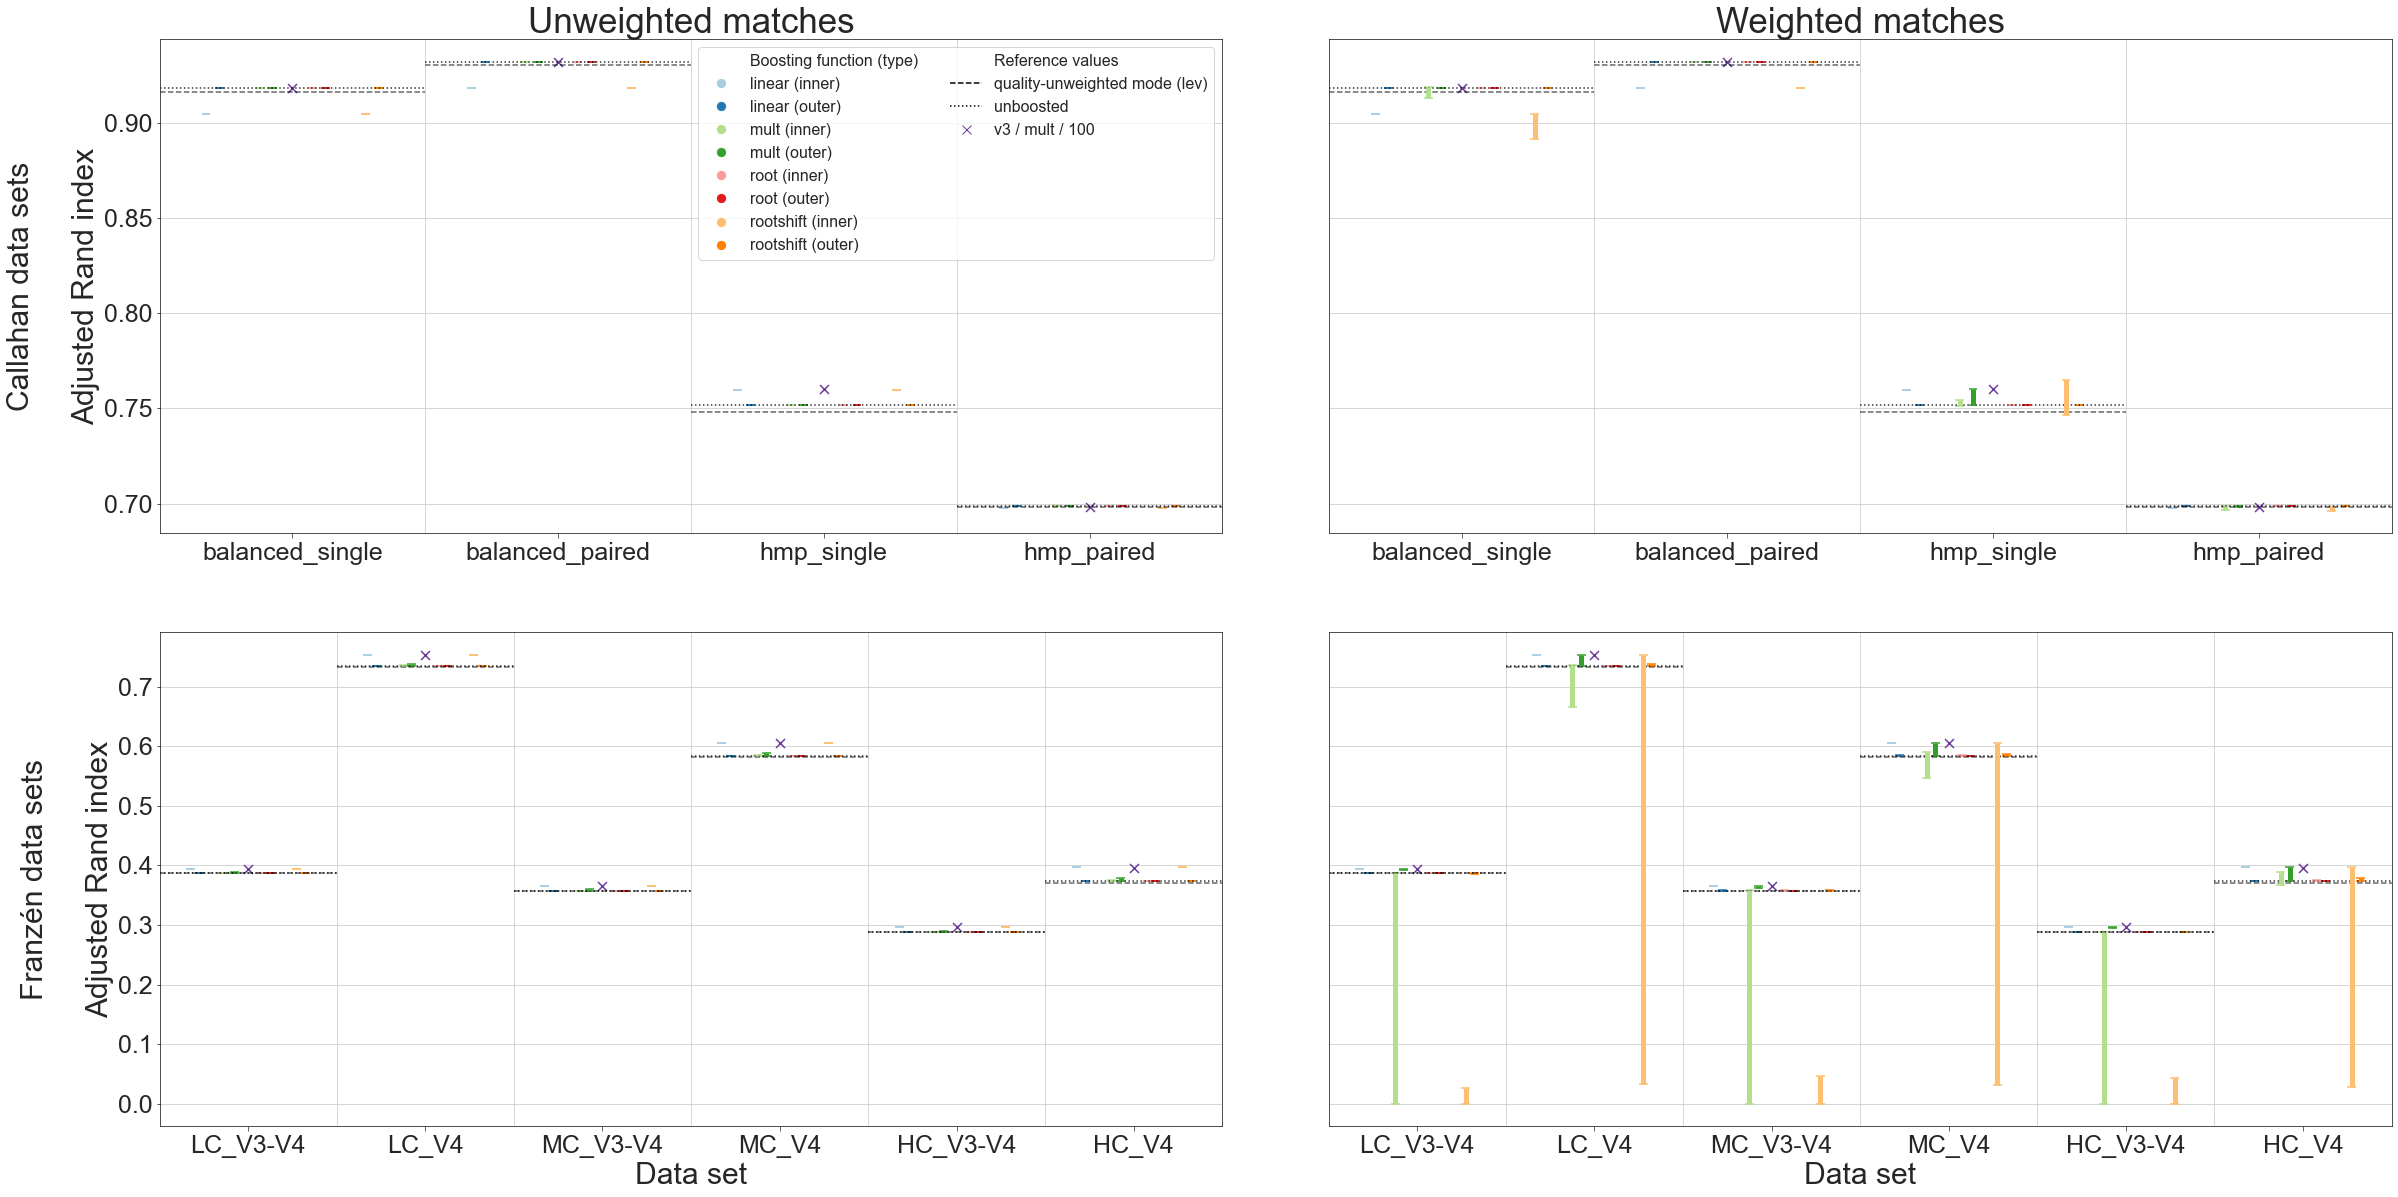

In [32]:
portions = [('Callahan data sets', df_callahan_gefast_joined_mean_avg, ['balanced_single', 'balanced_paired', 'hmp_single', 'hmp_paired']), 
            ('Franzén data sets', df_franzen_gefast_joined_mean_avg, ['LC_V3-V4', 'LC_V4', 'MC_V3-V4', 'MC_V4', 'HC_V3-V4', 'HC_V4'])]
modes = (mode, qmode)
metric = 'adjrandindex'
overview_plot(portions, modes, metric, qw_option, (best_v, best_b, best_bp), leg_positions = [(0, 0, 'best')])

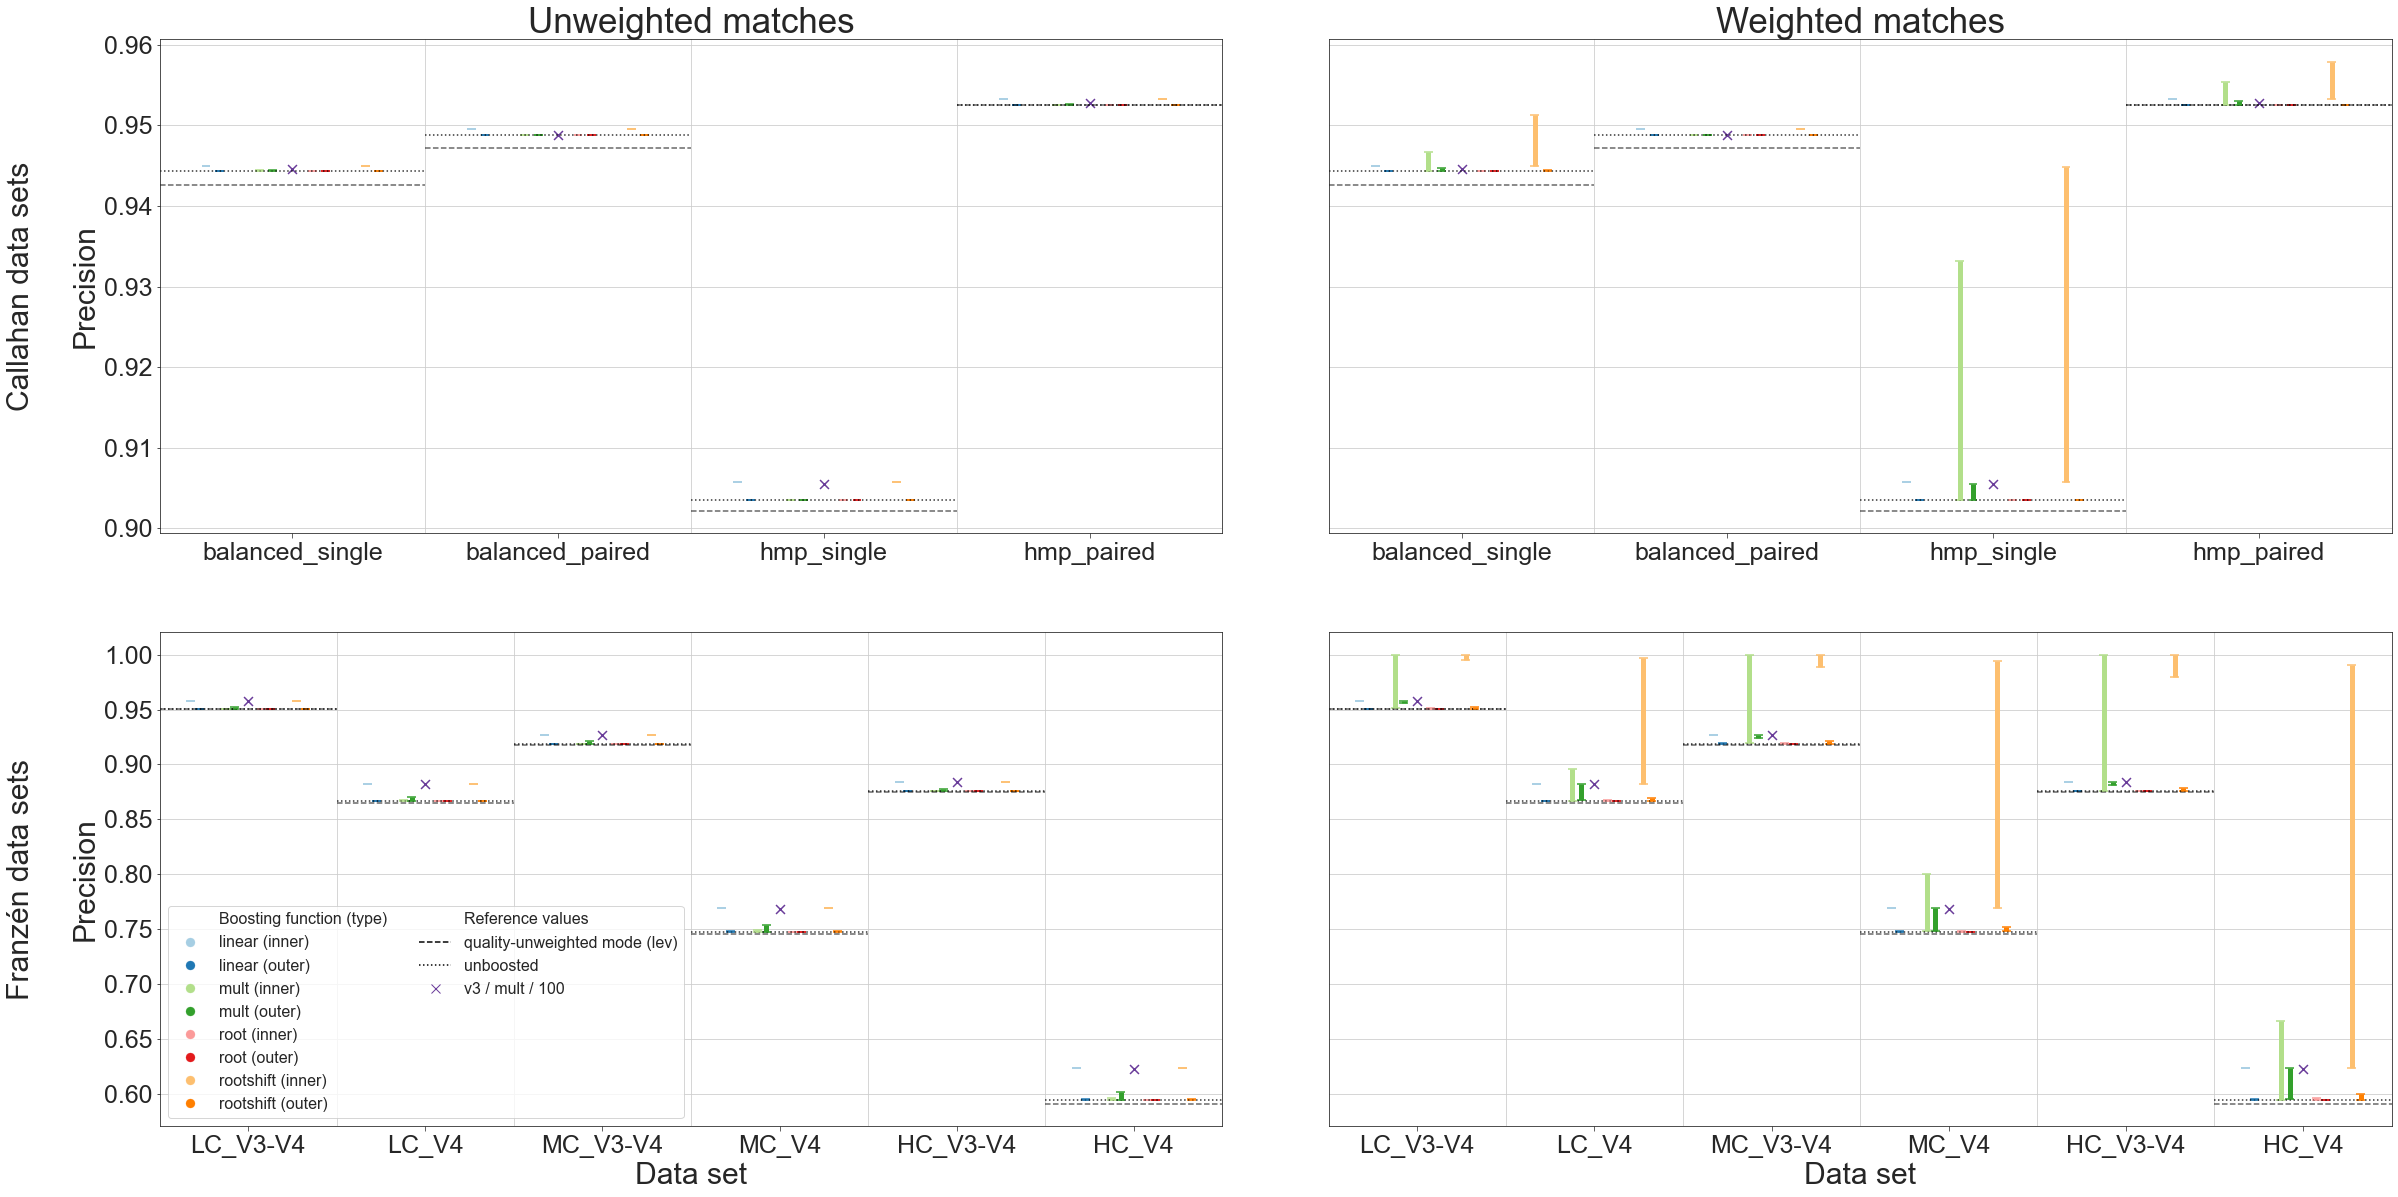

In [33]:
portions = [('Callahan data sets', df_callahan_gefast_joined_mean_avg, ['balanced_single', 'balanced_paired', 'hmp_single', 'hmp_paired']), 
            ('Franzén data sets', df_franzen_gefast_joined_mean_avg, ['LC_V3-V4', 'LC_V4', 'MC_V3-V4', 'MC_V4', 'HC_V3-V4', 'HC_V4'])]
modes = (mode, qmode)
metric = 'precision'
overview_plot(portions, modes, metric, qw_option, (best_v, best_b, best_bp))

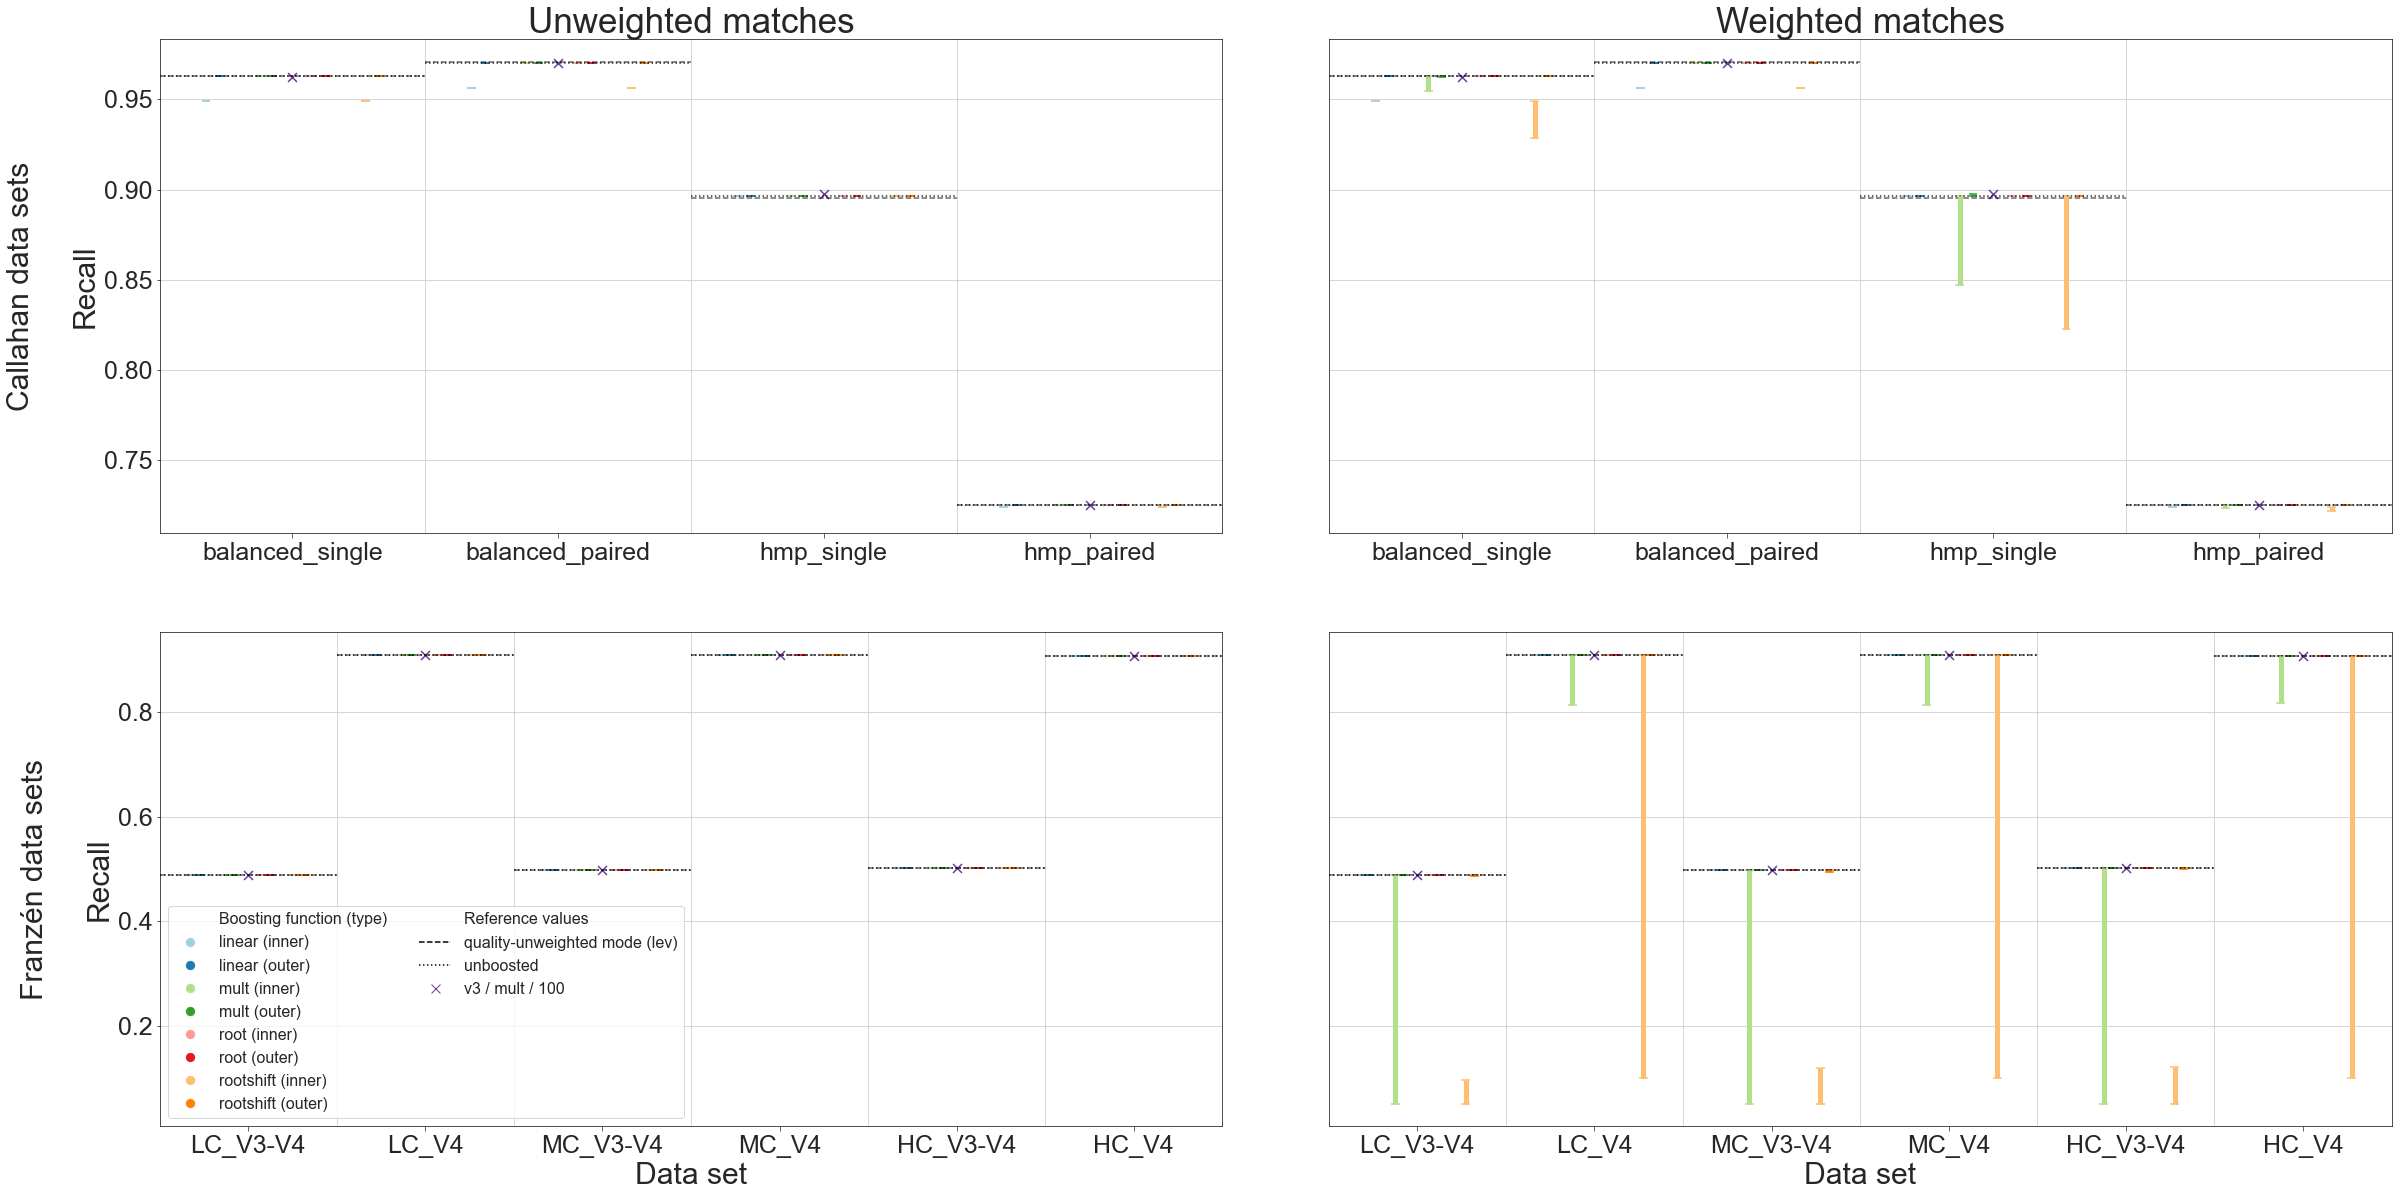

In [34]:
portions = [('Callahan data sets', df_callahan_gefast_joined_mean_avg, ['balanced_single', 'balanced_paired', 'hmp_single', 'hmp_paired']), 
            ('Franzén data sets', df_franzen_gefast_joined_mean_avg, ['LC_V3-V4', 'LC_V4', 'MC_V3-V4', 'MC_V4', 'HC_V3-V4', 'HC_V4'])]
modes = (mode, qmode)
metric = 'recall'
overview_plot(portions, modes, metric, qw_option, (best_v, best_b, best_bp))

Similar tendencies compared to maximum, but more pronounced differences between V3-V4 and V4.

-- *N-best average clustering quality*

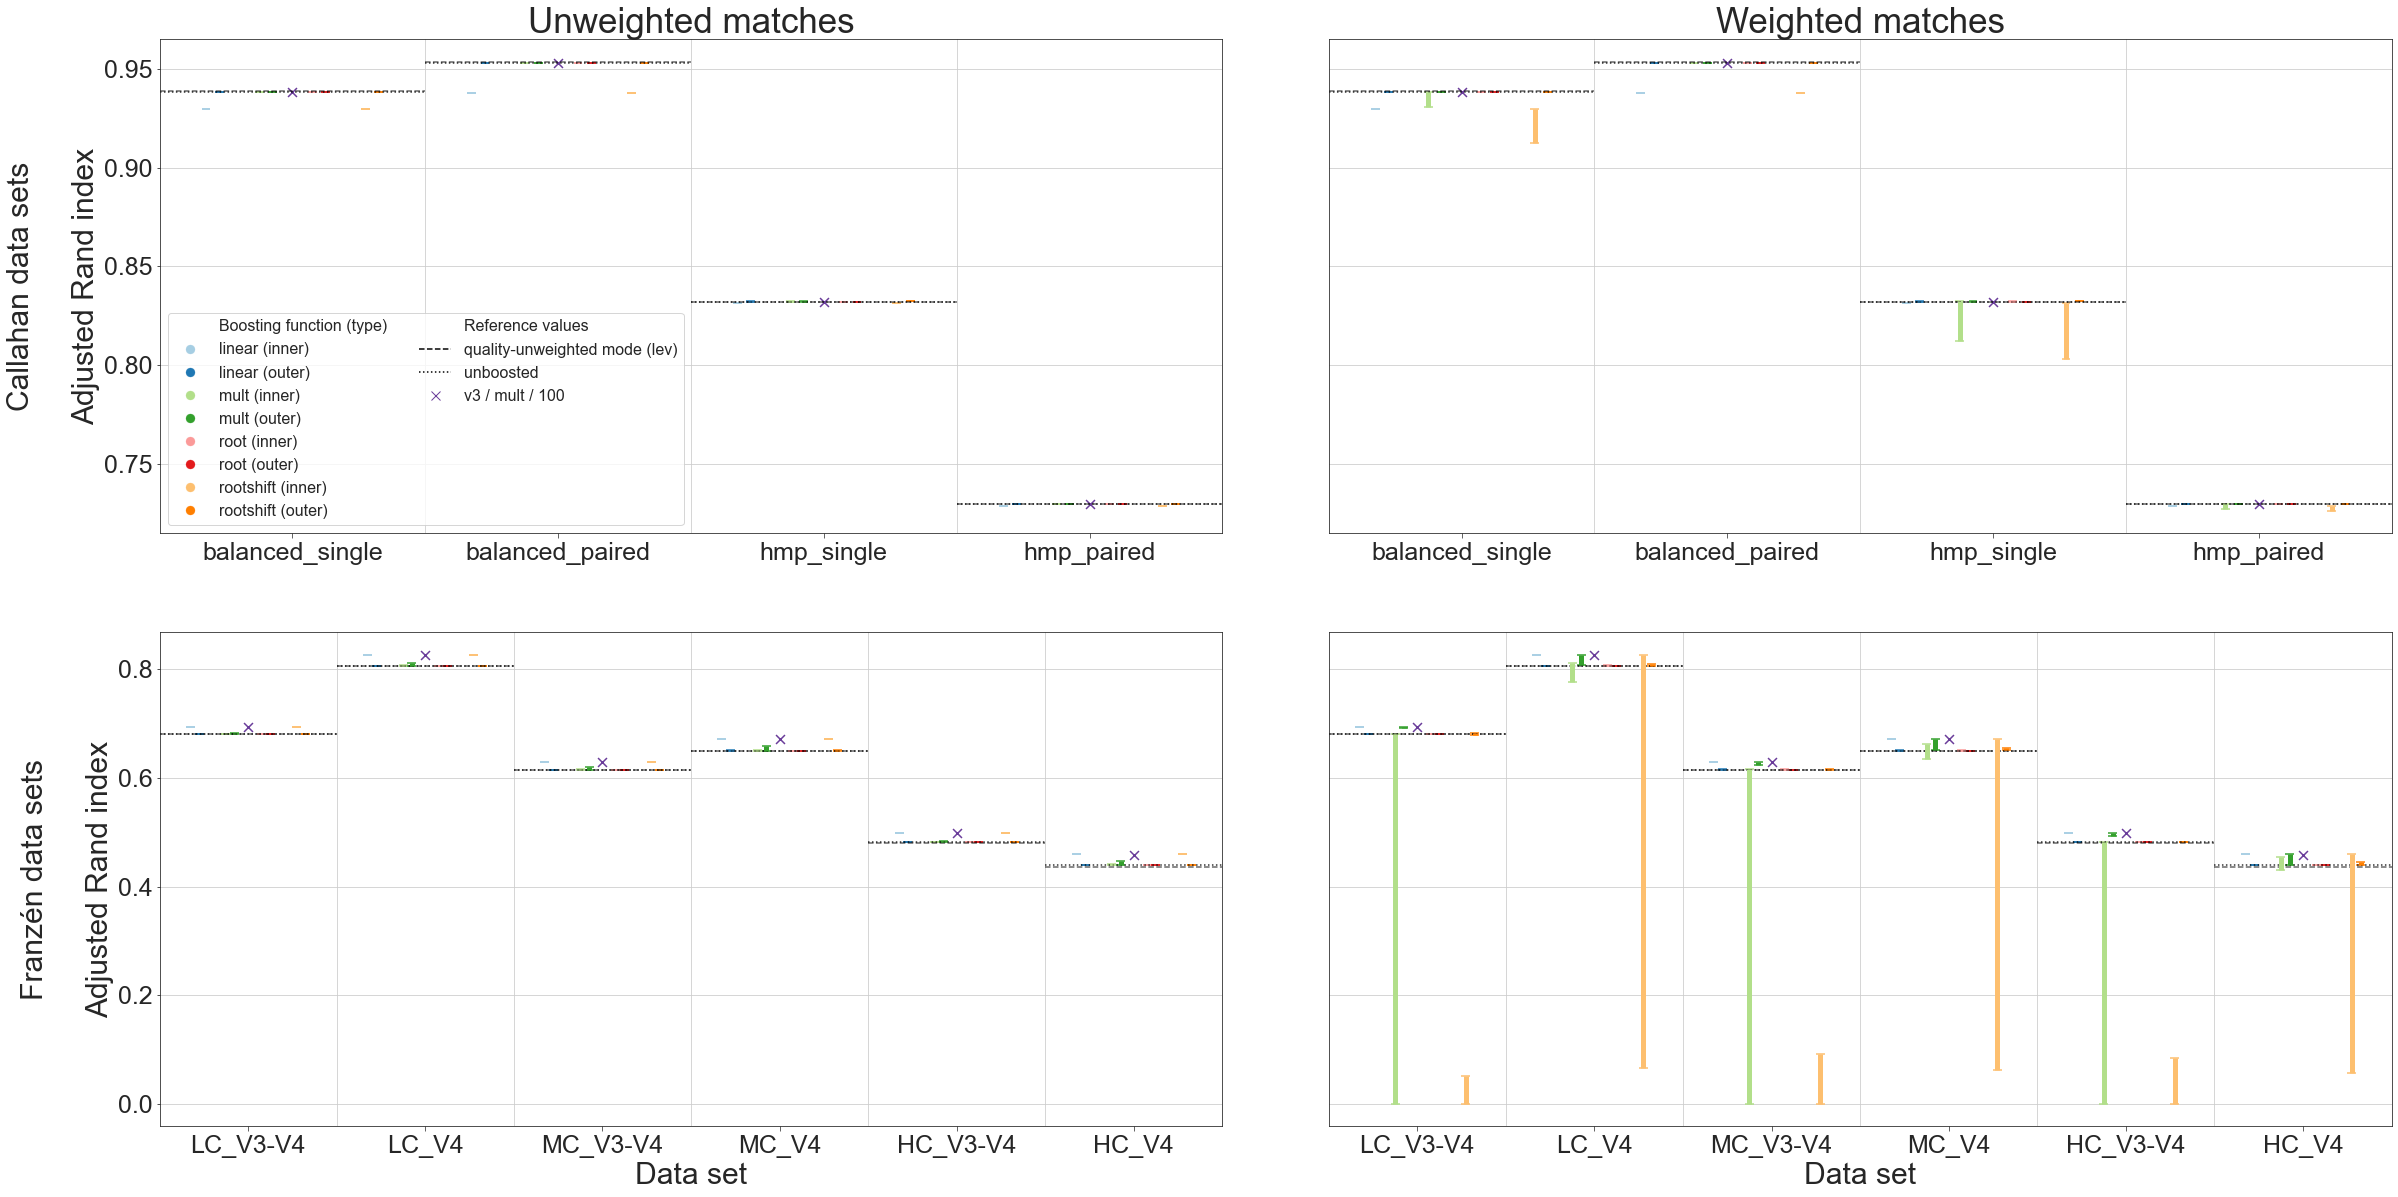

In [35]:
portions = [('Callahan data sets', df_callahan_gefast_joined_nbest_avg, ['balanced_single', 'balanced_paired', 'hmp_single', 'hmp_paired']), 
            ('Franzén data sets', df_franzen_gefast_joined_nbest_avg, ['LC_V3-V4', 'LC_V4', 'MC_V3-V4', 'MC_V4', 'HC_V3-V4', 'HC_V4'])]
modes = (mode, qmode)
metric = 'adjrandindex'
overview_plot(portions, modes, metric, qw_option, (best_v, best_b, best_bp), leg_positions = [(0, 0, 'lower left')])

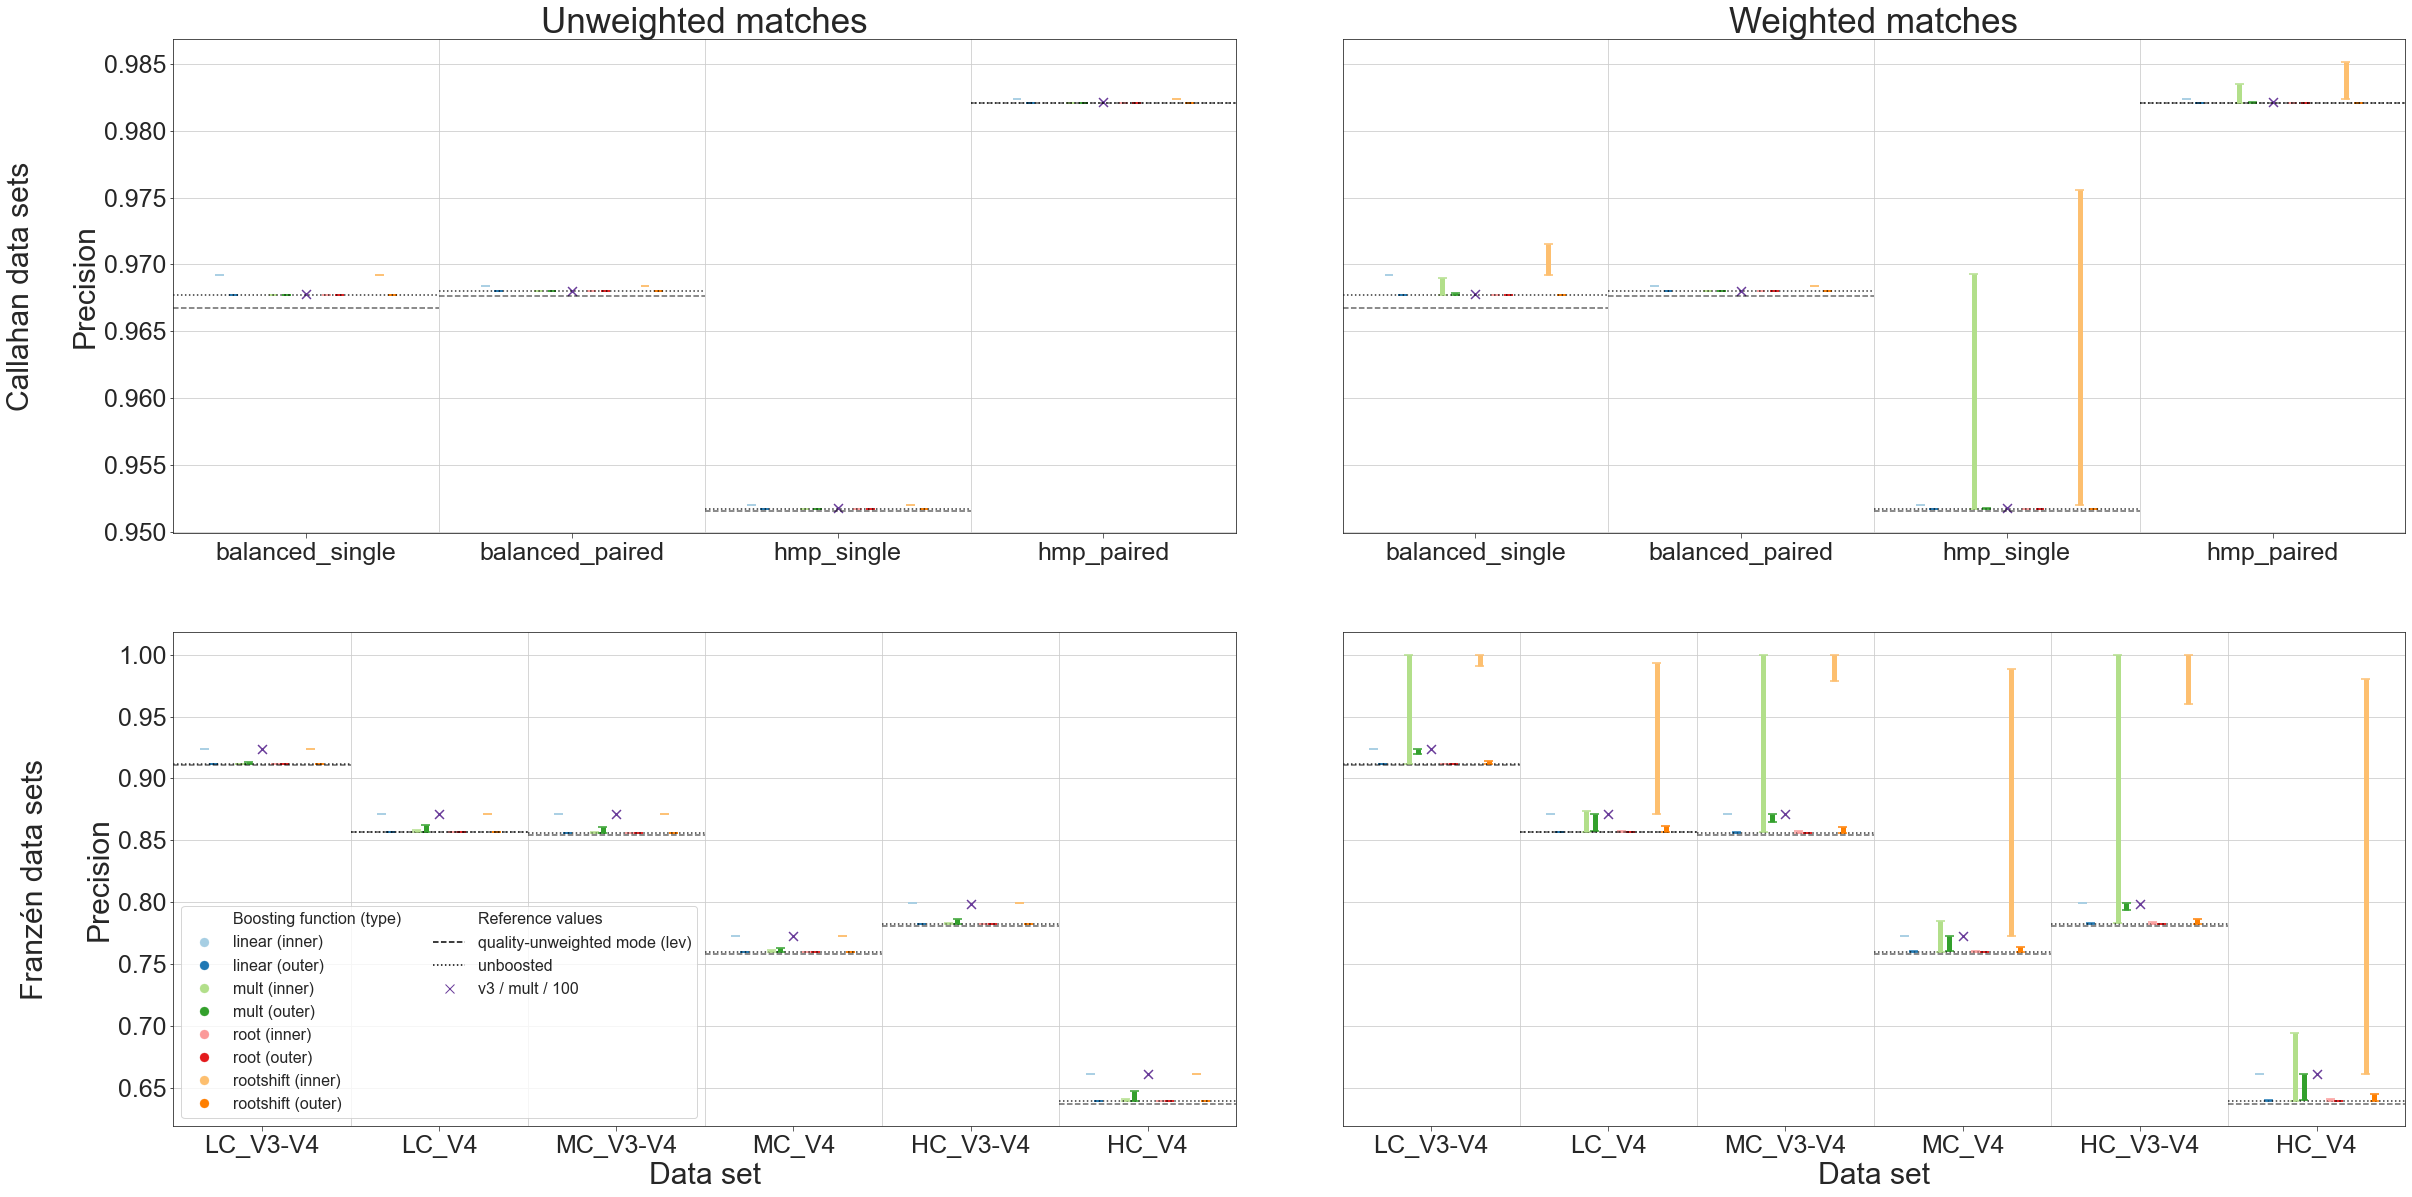

In [36]:
portions = [('Callahan data sets', df_callahan_gefast_joined_nbest_avg, ['balanced_single', 'balanced_paired', 'hmp_single', 'hmp_paired']), 
            ('Franzén data sets', df_franzen_gefast_joined_nbest_avg, ['LC_V3-V4', 'LC_V4', 'MC_V3-V4', 'MC_V4', 'HC_V3-V4', 'HC_V4'])]
modes = (mode, qmode)
metric = 'precision'
overview_plot(portions, modes, metric, qw_option, (best_v, best_b, best_bp), leg_positions = [(1, 0, 'lower left')])

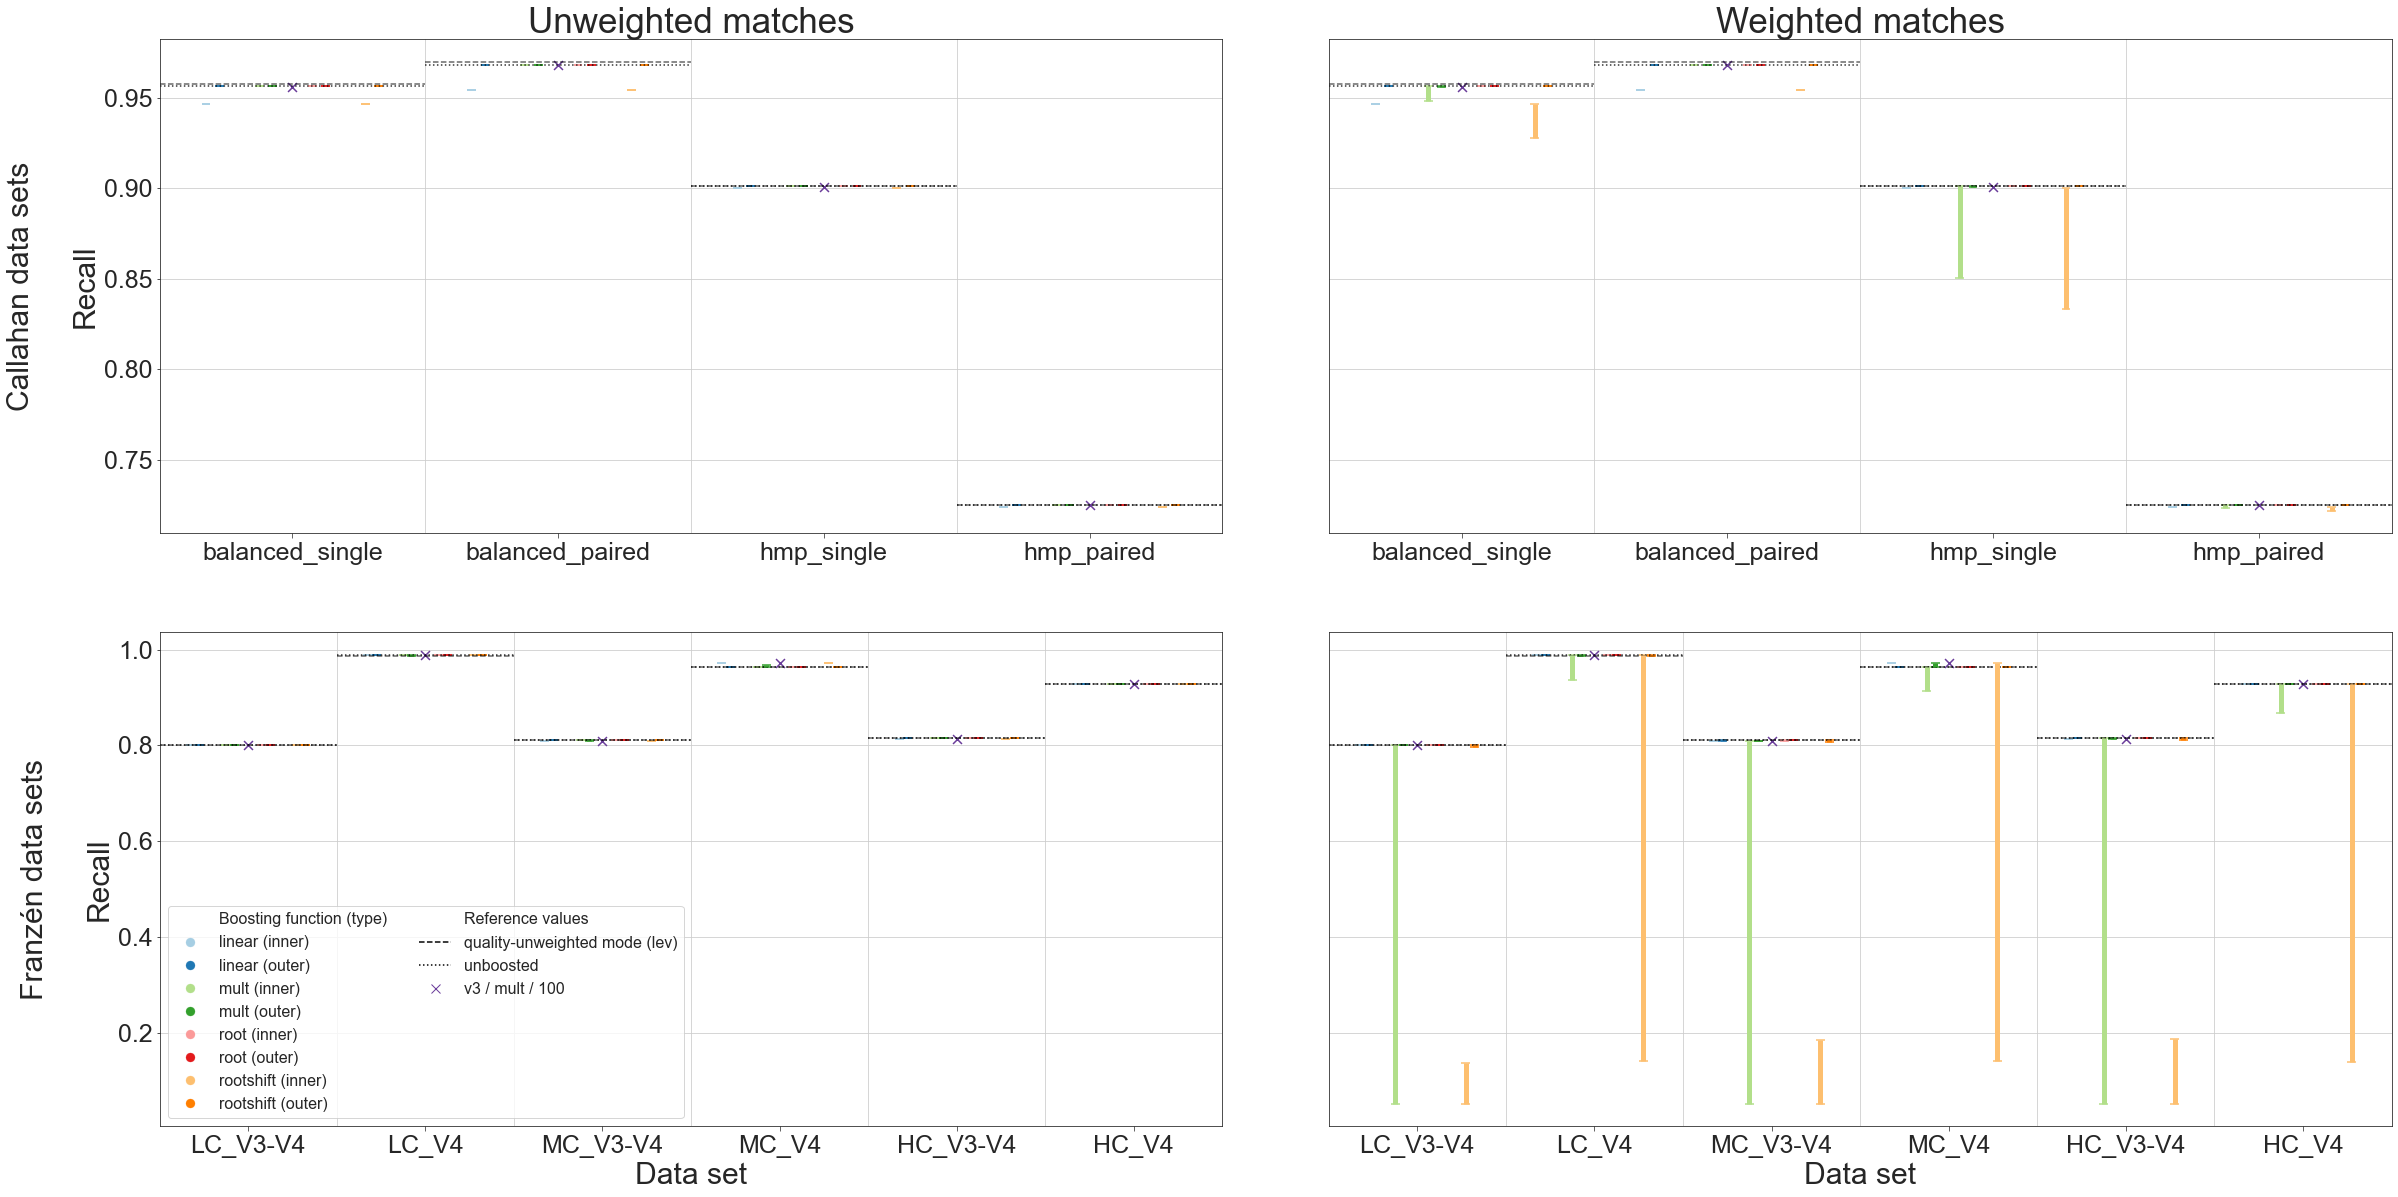

In [37]:
portions = [('Callahan data sets', df_callahan_gefast_joined_nbest_avg, ['balanced_single', 'balanced_paired', 'hmp_single', 'hmp_paired']), 
            ('Franzén data sets', df_franzen_gefast_joined_nbest_avg, ['LC_V3-V4', 'LC_V4', 'MC_V3-V4', 'MC_V4', 'HC_V3-V4', 'HC_V4'])]
modes = (mode, qmode)
metric = 'recall'
overview_plot(portions, modes, metric, qw_option, (best_v, best_b, best_bp))

The tendencies were very similar to average, but the differences between V3-V4 and V4 are again less pronounced.

### Comparison with USEARCH and VSEARCH

Compares the clustering quality of the quality-unweighted mode, the best unboosted and boosted variant with USEARCH and VSEARCH.

In [38]:
def avg_diff_multiple_uvsearch(portions, ref, cmps, metric = 'adjrandindex'):
    
    ref_tool, ref_mode = ref
    
    df_columns = ['data_group'] + ['%s / %s / %s / %s / %s' % (m, v, q, b, bp) for m, v, q, b, bp in cmps]
    
    rows = []
    for ref_df, df, data_set_groups, gt in portions:
        for (name, dsg) in data_set_groups:            
            ref_grp = ref_df.loc[(ref_df['data_set'].isin(dsg)) & (ref_df['gt'] == gt) & (ref_df['tool'] == ref_tool) & (ref_df['mode'] == ref_mode)]
            
            row = [name]
            for mode, v, qw, b, bp in cmps:
                cmp_grp = df.loc[df['data_set'].isin(dsg) & (df['gt'] == gt) & (df['mode'] == mode) & (df['v_opt'] == v) & (df['qw_opt'] == qw) & (df['b_opt'] == b) & (df['b_param'] == bp)]
                
                row.append(cmp_grp[metric].mean() - ref_grp[metric].mean())
            
            rows.append(row)
            
    return pd.DataFrame(rows, columns = df_columns)

**USEARCH**

-- *Maximum clustering quality*

In [39]:
for m in ['adjrandindex', 'precision', 'recall']:
    print('%s:' % rename_map[m])
    display(avg_diff_multiple_uvsearch([(df_franzen_uvsearch_joined_max_avg, df_franzen_gefast_joined_max_avg, [('V3-V4', ['LC_V3-V4', 'MC_V3-V4', 'HC_V3-V4']), ('V4', ['LC_V4', 'MC_V4', 'HC_V4'])], 'franzen'),
                            (df_callahan_uvsearch_joined_max_avg, df_callahan_gefast_joined_max_avg, [('paired', ['balanced_paired', 'hmp_paired']), ('single', ['balanced_single', 'hmp_single'])], 'callahan')], 
                           ('usearch', 'fast_size'), [(mode, 'none', 'none', 'none', 'none'), (qmode, best_ub, qw_option, 'unboosted', 'none'), (qmode, best_v, qw_option, best_b, best_bp)], metric = m))

Adjusted Rand index:


,data_group,lev / none / none / none / none,qlev / mw / ma / unboosted / none,qlev / v3 / ma / mult / 100
0,V3-V4,-0.073582,-0.072466,-0.049740
1,V4,-0.037451,-0.035833,-0.019740
2,paired,-0.090215,-0.090202,-0.090297
3,single,-0.036916,-0.036916,-0.036916


Precision:


,data_group,lev / none / none / none / none,qlev / mw / ma / unboosted / none,qlev / v3 / ma / mult / 100
0,V3-V4,-0.047402,-0.046528,-0.026811
1,V4,-0.045102,-0.046962,-0.045734
2,paired,0.003996,0.004012,0.004025
3,single,0.020997,0.020997,0.020997


Recall:


,data_group,lev / none / none / none / none,qlev / mw / ma / unboosted / none,qlev / v3 / ma / mult / 100
0,V3-V4,0.027213,0.028492,0.029041
1,V4,0.030639,0.035893,0.053413
2,paired,-0.099960,-0.099958,-0.100011
3,single,-0.049375,-0.049375,-0.049375


-- *Average clustering quality*

In [40]:
for m in ['adjrandindex', 'precision', 'recall']:
    print('%s:' % rename_map[m])
    display(avg_diff_multiple_uvsearch([(df_franzen_uvsearch_joined_mean_avg, df_franzen_gefast_joined_mean_avg, [('V3-V4', ['LC_V3-V4', 'MC_V3-V4', 'HC_V3-V4']), ('V4', ['LC_V4', 'MC_V4', 'HC_V4'])], 'franzen'),
                                        (df_callahan_uvsearch_joined_mean_avg, df_callahan_gefast_joined_mean_avg, [('paired', ['balanced_paired', 'hmp_paired']), ('single', ['balanced_single', 'hmp_single'])], 'callahan')], 
                                       ('usearch', 'fast_size'), [(mode, 'none', 'none', 'none', 'none'), (qmode, best_ub, qw_option, 'unboosted', 'none'), (qmode, best_v, qw_option, best_b, best_bp)], metric = m))

Adjusted Rand index:


,data_group,lev / none / none / none / none,qlev / mw / ma / unboosted / none,qlev / v3 / ma / mult / 100
0,V3-V4,-0.190373,-0.190023,-0.182659
1,V4,0.046680,0.049034,0.070070
2,paired,-0.014875,-0.013937,-0.013965
3,single,-0.003043,-0.000162,0.004063


Precision:


,data_group,lev / none / none / none / none,qlev / mw / ma / unboosted / none,qlev / v3 / ma / mult / 100
0,V3-V4,0.190410,0.190970,0.198829
1,V4,0.130885,0.133392,0.154844
2,paired,0.058615,0.059490,0.059580
3,single,0.019663,0.021254,0.022329


Recall:


,data_group,lev / none / none / none / none,qlev / mw / ma / unboosted / none,qlev / v3 / ma / mult / 100
0,V3-V4,-0.362025,-0.362169,-0.362975
1,V4,-0.053203,-0.053204,-0.053762
2,paired,-0.107858,-0.108213,-0.108260
3,single,-0.022070,-0.021777,-0.021312


-- *N-best average clustering quality*

In [41]:
for m in ['adjrandindex', 'precision', 'recall']:
    print('%s:' % rename_map[m])
    display(avg_diff_multiple_uvsearch([(df_franzen_uvsearch_joined_nbest_avg, df_franzen_gefast_joined_nbest_avg, [('V3-V4', ['LC_V3-V4', 'MC_V3-V4', 'HC_V3-V4']), ('V4', ['LC_V4', 'MC_V4', 'HC_V4'])], 'franzen'),
                                        (df_callahan_uvsearch_joined_nbest_avg, df_callahan_gefast_joined_nbest_avg, [('paired', ['balanced_paired', 'hmp_paired']), ('single', ['balanced_single', 'hmp_single'])], 'callahan')], 
                                       ('usearch', 'fast_size'), [(mode, 'none', 'none', 'none', 'none'), (qmode, best_ub, qw_option, 'unboosted', 'none'), (qmode, best_v, qw_option, best_b, best_bp)], metric = m))

Adjusted Rand index:


,data_group,lev / none / none / none / none,qlev / mw / ma / unboosted / none,qlev / v3 / ma / mult / 100
0,V3-V4,-0.065049,-0.064325,-0.049821
1,V4,0.016450,0.018056,0.038797
2,paired,-0.071815,-0.072229,-0.072287
3,single,-0.033368,-0.033450,-0.033569


Precision:


,data_group,lev / none / none / none / none,qlev / mw / ma / unboosted / none,qlev / v3 / ma / mult / 100
0,V3-V4,0.069027,0.070126,0.084969
1,V4,0.028302,0.029442,0.045843
2,paired,0.023891,0.024065,0.024106
3,single,-0.000595,-0.000070,0.000038


Recall:


,data_group,lev / none / none / none / none,qlev / mw / ma / unboosted / none,qlev / v3 / ma / mult / 100
0,V3-V4,-0.112887,-0.113138,-0.114613
1,V4,0.006831,0.007353,0.010540
2,paired,-0.104986,-0.105809,-0.105860
3,single,-0.019114,-0.019862,-0.020172


USEARCH was better in maximum quality on all categories (especially paired, mainly due to hmp_paired).   
The boosted variant, however, tended to be more robust on V4 data (N-best).

**VSEARCH**

-- *Maximum clustering quality*

In [42]:
for m in ['adjrandindex', 'precision', 'recall']:
    print('%s:' % rename_map[m])
    display(avg_diff_multiple_uvsearch([(df_franzen_uvsearch_joined_max_avg, df_franzen_gefast_joined_max_avg, [('V3-V4', ['LC_V3-V4', 'MC_V3-V4', 'HC_V3-V4']), ('V4', ['LC_V4', 'MC_V4', 'HC_V4'])], 'franzen'),
                                        (df_callahan_uvsearch_joined_max_avg, df_callahan_gefast_joined_max_avg, [('paired', ['balanced_paired', 'hmp_paired']), ('single', ['balanced_single', 'hmp_single'])], 'callahan')], 
                                       ('vsearch', 'size'), [(mode, 'none', 'none', 'none', 'none'), (qmode, best_ub, qw_option, 'unboosted', 'none'), (qmode, best_v, qw_option, best_b, best_bp)], metric = m))

Adjusted Rand index:


,data_group,lev / none / none / none / none,qlev / mw / ma / unboosted / none,qlev / v3 / ma / mult / 100
0,V3-V4,-0.092605,-0.091489,-0.068763
1,V4,-0.040135,-0.038518,-0.022425
2,paired,-0.099390,-0.099378,-0.099473
3,single,-0.041363,-0.041363,-0.041363


Precision:


,data_group,lev / none / none / none / none,qlev / mw / ma / unboosted / none,qlev / v3 / ma / mult / 100
0,V3-V4,-0.057154,-0.056280,-0.036563
1,V4,-0.050758,-0.052618,-0.051390
2,paired,0.002957,0.002973,0.002986
3,single,0.017938,0.017938,0.017938


Recall:


,data_group,lev / none / none / none / none,qlev / mw / ma / unboosted / none,qlev / v3 / ma / mult / 100
0,V3-V4,0.006412,0.007690,0.008240
1,V4,0.035412,0.040666,0.058187
2,paired,-0.109056,-0.109054,-0.109108
3,single,-0.048321,-0.048321,-0.048321


-- *Average clustering quality*

In [43]:
for m in ['adjrandindex', 'precision', 'recall']:
    print('%s:' % rename_map[m])
    display(avg_diff_multiple_uvsearch([(df_franzen_uvsearch_joined_mean_avg, df_franzen_gefast_joined_mean_avg, [('V3-V4', ['LC_V3-V4', 'MC_V3-V4', 'HC_V3-V4']), ('V4', ['LC_V4', 'MC_V4', 'HC_V4'])], 'franzen'),
                                        (df_callahan_uvsearch_joined_mean_avg, df_callahan_gefast_joined_mean_avg, [('paired', ['balanced_paired', 'hmp_paired']), ('single', ['balanced_single', 'hmp_single'])], 'callahan')], 
                                       ('vsearch', 'size'), [(mode, 'none', 'none', 'none', 'none'), (qmode, best_ub, qw_option, 'unboosted', 'none'), (qmode, best_v, qw_option, best_b, best_bp)], metric = m))

Adjusted Rand index:


,data_group,lev / none / none / none / none,qlev / mw / ma / unboosted / none,qlev / v3 / ma / mult / 100
0,V3-V4,-0.199748,-0.199399,-0.192035
1,V4,0.046968,0.049323,0.070358
2,paired,-0.019140,-0.018202,-0.018230
3,single,-0.004556,-0.001675,0.002550


Precision:


,data_group,lev / none / none / none / none,qlev / mw / ma / unboosted / none,qlev / v3 / ma / mult / 100
0,V3-V4,0.188518,0.189078,0.196937
1,V4,0.132924,0.135430,0.156883
2,paired,0.058868,0.059743,0.059832
3,single,0.020795,0.022387,0.023461


Recall:


,data_group,lev / none / none / none / none,qlev / mw / ma / unboosted / none,qlev / v3 / ma / mult / 100
0,V3-V4,-0.375628,-0.375771,-0.376577
1,V4,-0.055658,-0.055658,-0.056217
2,paired,-0.111210,-0.111564,-0.111611
3,single,-0.023777,-0.023484,-0.023019


-- *N-best average clustering quality*

In [44]:
for m in ['adjrandindex', 'precision', 'recall']:
    print('%s:' % rename_map[m])
    display(avg_diff_multiple_uvsearch([(df_franzen_uvsearch_joined_nbest_avg, df_franzen_gefast_joined_nbest_avg, [('V3-V4', ['LC_V3-V4', 'MC_V3-V4', 'HC_V3-V4']), ('V4', ['LC_V4', 'MC_V4', 'HC_V4'])], 'franzen'),
                                        (df_callahan_uvsearch_joined_nbest_avg, df_callahan_gefast_joined_nbest_avg, [('paired', ['balanced_paired', 'hmp_paired']), ('single', ['balanced_single', 'hmp_single'])], 'callahan')], 
                                       ('vsearch', 'size'), [(mode, 'none', 'none', 'none', 'none'), (qmode, best_ub, qw_option, 'unboosted', 'none'), (qmode, best_v, qw_option, best_b, best_bp)], metric = m))

Adjusted Rand index:


,data_group,lev / none / none / none / none,qlev / mw / ma / unboosted / none,qlev / v3 / ma / mult / 100
0,V3-V4,-0.079470,-0.078746,-0.064243
1,V4,0.011455,0.013061,0.033802
2,paired,-0.078360,-0.078774,-0.078831
3,single,-0.037740,-0.037823,-0.037941


Precision:


,data_group,lev / none / none / none / none,qlev / mw / ma / unboosted / none,qlev / v3 / ma / mult / 100
0,V3-V4,0.058895,0.059994,0.074837
1,V4,0.023550,0.024691,0.041092
2,paired,0.022995,0.023170,0.023211
3,single,-0.001364,-0.000838,-0.000730


Recall:


,data_group,lev / none / none / none / none,qlev / mw / ma / unboosted / none,qlev / v3 / ma / mult / 100
0,V3-V4,-0.125227,-0.125478,-0.126954
1,V4,0.004531,0.005053,0.008240
2,paired,-0.111004,-0.111826,-0.111877
3,single,-0.020933,-0.021681,-0.021991


Similar to USEARCH.